# Imports + connect

In [1]:
import sqlite3, re, unicodedata
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import sys

# Add project root (one level above /notebook) to sys.path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

DB_PATH = ROOT / "data" / "takeaway.db"
con = sqlite3.connect(DB_PATH)

pd.set_option("display.max_columns", 200)


# Tables

In [2]:
tables = pd.read_sql_query("""
SELECT name
FROM sqlite_master
WHERE type='table'
  AND name NOT LIKE 'sqlite_%'
ORDER BY name;
""", con)
tables


name
0                categories
1    categories_restaurants
2                 locations
3  locations_to_restaurants
4                 menuItems
5               restaurants

## Helpers 

In [4]:
def norm_text(x):
    if x is None: return None
    x = str(x).lower().strip()
    x = unicodedata.normalize("NFKD", x)
    x = "".join(c for c in x if not unicodedata.combining(c))
    x = re.sub(r"[^\w\s]", " ", x)
    return re.sub(r"\s+", " ", x).strip()

def contains_any(text, patterns):
    if text is None: return False
    t = norm_text(text)
    return any(re.search(p, t) for p in patterns)

def price_eur(x):
    try:
        v = float(x)
        return v if 0 < v < 200 else np.nan
    except:
        return np.nan


# Q1 : What is the price distribution of menu items?

In [5]:
df_price = pd.read_sql("""
SELECT price
FROM menuItems
WHERE price IS NOT NULL
""", con)

df_price["price_eur"] = df_price["price"].map(price_eur)
df_price = df_price.dropna()


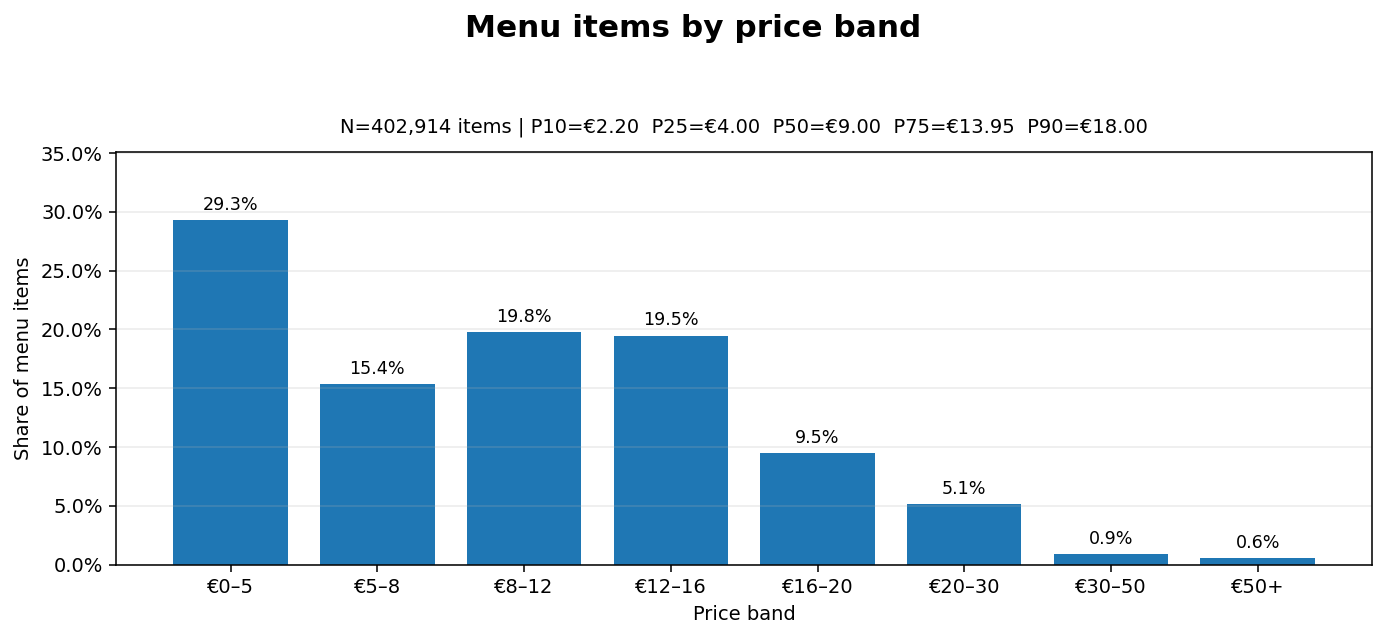

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ----------------------------
# Data
# ----------------------------
s = df_price["price_eur"].astype(float)
s = s[(s > 0) & (s < 500)]  # keep sanity filter internally, but don't print it

bins   = [0, 5, 8, 12, 16, 20, 30, 50, np.inf]
labels = ["€0–5", "€5–8", "€8–12", "€12–16", "€16–20", "€20–30", "€30–50", "€50+"]

band = pd.cut(s, bins=bins, labels=labels, right=False)
share = (band.value_counts(normalize=True).reindex(labels).fillna(0) * 100)

# Percentiles requested
ps = [0.10, 0.25, 0.50, 0.75, 0.90]
p = s.quantile(ps)
p10, p25, p50, p75, p90 = [float(p.loc[q]) for q in ps]

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 4.6), dpi=140)

x = np.arange(len(labels))
bars = ax.bar(x, share.values, width=0.78)

ax.set_xticks(x, labels)
ax.set_ylabel("Share of menu items")
ax.set_xlabel("Price band")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

ymax = max(share.max() * 1.20, 5)
ax.set_ylim(0, ymax)

# Bar labels
for rect, v in zip(bars, share.values):
	if v <= 0:
		continue
	ax.text(
		rect.get_x() + rect.get_width() / 2,
		rect.get_height() + ymax * 0.015,
		f"{v:.1f}%",
		ha="center", va="bottom", fontsize=9
	)

# Title + subtitle (no overlap)
n = len(s)
fig.suptitle("Menu items by price band", fontsize=16, fontweight="bold", y=0.98)

subtitle = (
	f"N={n:,} items | "
	f"P10=€{p10:.2f}  P25=€{p25:.2f}  P50=€{p50:.2f}  P75=€{p75:.2f}  P90=€{p90:.2f}"
)
ax.set_title(subtitle, fontsize=10, pad=10)

# Leave room for the suptitle
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Insights:

1.  ~64.5% of items under €12

2. IQR sits between €4.00 and €13.95

3. P50 = €9.00 → standard menu item around €9

4. Only ~6.6% of items are €20+

5. 90% of items  ≤ €18

6. Business insights :

    - “mass market” sits roughly €4–€14, most items <= €18, limited premium segment

    - For restaurant partners:  pricing new items near €8–€16 (where most of the market competes); €20+ for premium dishes, or upsell combos

# Q2: Distribution of restaurants per location: How many restaurants can deliver to each postal code?

## Assumptions:

- “Location” = postal code



In [19]:
df_pc = pd.read_sql("""
SELECT
  l.postalCode AS postal_code,
  COUNT(DISTINCT lr.restaurant_id) AS n_restaurants
FROM locations_to_restaurants lr
JOIN locations l
  ON CAST(l.ID AS TEXT) = CAST(lr.location_id AS TEXT)
WHERE l.postalCode IS NOT NULL
GROUP BY l.postalCode
""", con)


In [20]:
df_pc["postal_code"] = df_pc["postal_code"].astype(str).str.strip()
df_pc = df_pc[~df_pc["postal_code"].str.contains(r"[A-Za-z]", regex=True)].copy()
df_pc["n_restaurants"] = pd.to_numeric(df_pc["n_restaurants"], errors="coerce")
df_pc = df_pc.dropna(subset=["n_restaurants"])

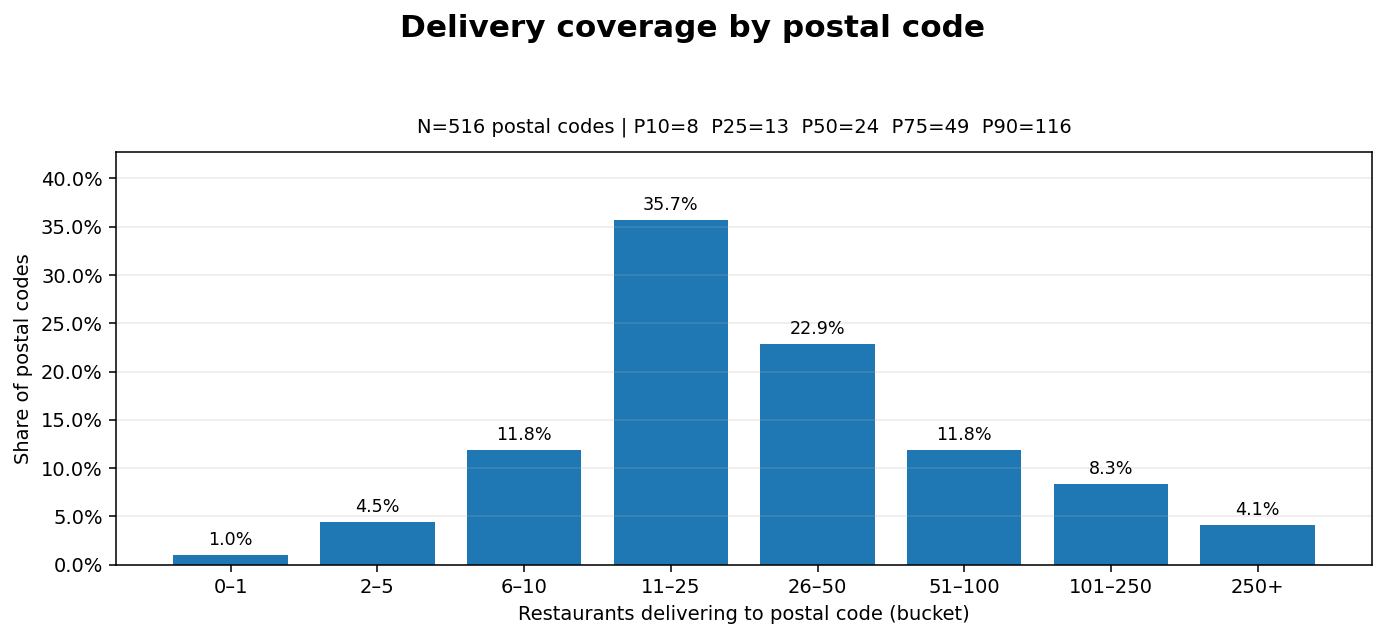

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

x = df_pc["n_restaurants"].astype(int)

# Percentiles for subtitle
p = x.quantile([0.10, 0.25, 0.50, 0.75, 0.90])
p10, p25, p50, p75, p90 = [float(p.loc[q]) for q in [0.10, 0.25, 0.50, 0.75, 0.90]]

# Buckets (keep yours; they're intuitive)
bins   = [0, 1, 5, 10, 25, 50, 100, 250, np.inf]
labels = ["0–1", "2–5", "6–10", "11–25", "26–50", "51–100", "101–250", "250+"]

bucket = pd.cut(x, bins=bins, labels=labels, right=True, include_lowest=True)
share = (bucket.value_counts(normalize=True).reindex(labels).fillna(0) * 100)

fig, ax = plt.subplots(figsize=(10, 4.6), dpi=140)
bars = ax.bar(np.arange(len(labels)), share.values, width=0.78)

ax.set_xticks(np.arange(len(labels)), labels)
ax.set_ylabel("Share of postal codes")
ax.set_xlabel("Restaurants delivering to postal code (bucket)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

ymax = max(share.max() * 1.20, 5)
ax.set_ylim(0, ymax)

for rect, v in zip(bars, share.values):
	if v <= 0:
		continue
	ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + ymax*0.015, f"{v:.1f}%",
			ha="center", va="bottom", fontsize=9)

fig.suptitle("Delivery coverage by postal code", fontsize=16, fontweight="bold", y=0.98)
ax.set_title(
	f"N={len(x):,} postal codes | P10={p10:.0f}  P25={p25:.0f}  P50={p50:.0f}  P75={p75:.0f}  P90={p90:.0f}",
	fontsize=10, pad=10
)

fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


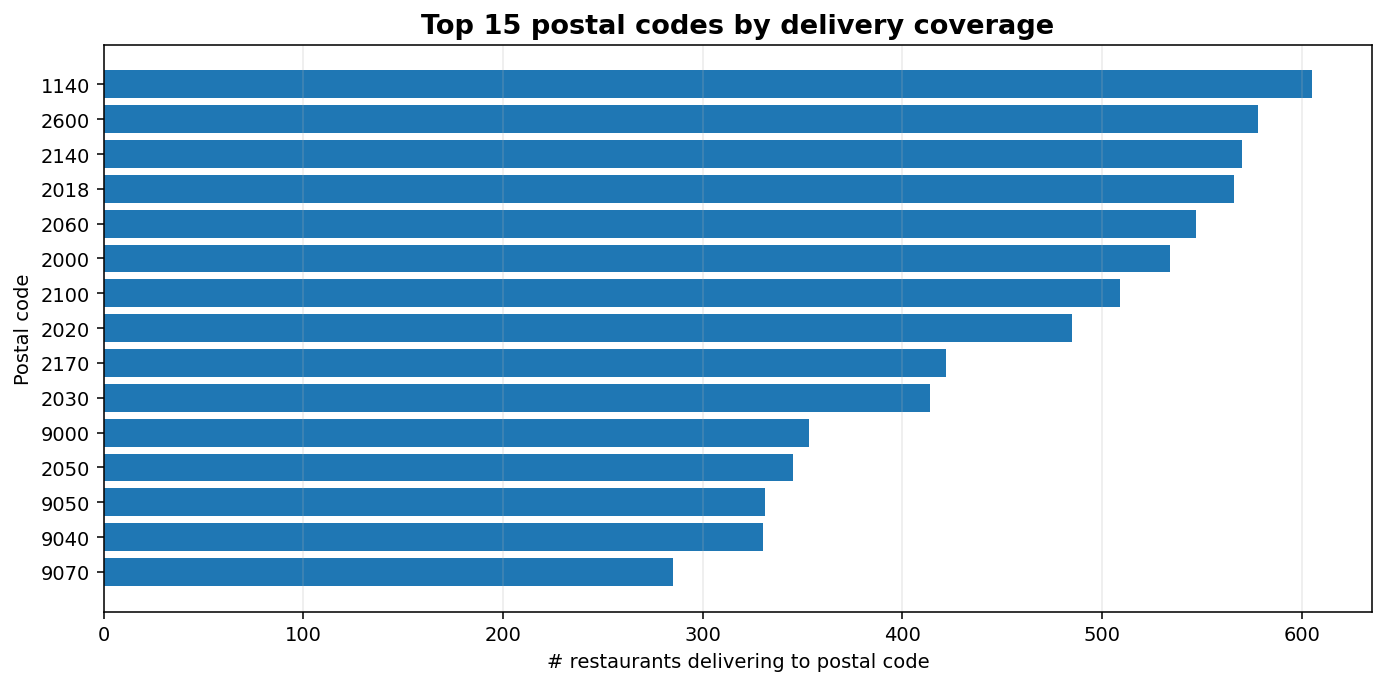

In [22]:
top = df_pc.sort_values("n_restaurants", ascending=False).head(15).copy()

fig, ax = plt.subplots(figsize=(10, 5), dpi=140)
ax.barh(top["postal_code"].astype(str), top["n_restaurants"])
ax.invert_yaxis()
ax.set_xlabel("# restaurants delivering to postal code")
ax.set_ylabel("Postal code")
ax.set_title("Top 15 postal codes by delivery coverage", fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")
plt.tight_layout()
plt.show()


## Insights :

1. Market structure: most customers live in areas with ~13–49 choices, but there’s a clear split between underserved (≤5) and hyper-competitive (>100) postal codes.

2. For restaurant partners:

    - In low-coverage areas (≤10): expansion/availability is a growth lever—being present yields high visibility.

    - In high-coverage areas (≥50/100): differentiation matters more—optimize delivery fee/min order, standout menu bundles, and rating visibility.

3. For platform ops / growth:

    - Target partner acquisition in the ≤5 and 6–10 buckets (coverage gap).

    - In dense cores, focus on quality controls + ranking/promo mechanics rather than adding more supply.

# Q3 : Top 10 pizza restaurants by rating:

Assumptions:

1. “pizza restaurant”: it has at least 3 pizza-related menu items, detected via keyword matching in menuItems.name (and optionally menuItems.description)

2. Ratings source:

    - restaurants.ratings = raw average rating (0–5)

    - restaurants.ratingsNumber = number of reviews (vote count)

3. Why raw ratings can be misleading:

    - Restaurant A: 5.0 rating from 2 reviews

    - Restaurant B: 4.7 rating from 800 reviews

    - A naïve sort puts A above B, but A’s score is much less reliable.

4. Bayesian-adjusted rating (weighted rating):

    - Trusts restaurants with many reviews (keeps their rating close to raw)

    - Is skeptical of restaurants with few reviews (pull them toward the overall pizza average)

    - bayes_rating= 
    $$
    \text{Bayes Rating} = \frac{v}{v + m} \, R \; + \; \frac{m}{v + m} \, C
    $$

    where :

    R  = restaurant’s raw rating

    v = number of reviews (rating_count)

    C = average rating across all pizza restaurants (the “category baseline”)

    m = typical review count across pizza restaurants (the “strength” of the baseline)





In [23]:
df = pd.read_sql("""
SELECT
  r.primarySlug,
  r.name          AS restaurant,
  r.city          AS city,
  r.ratings       AS rating,
  r.ratingsNumber AS rating_count,
  m.name          AS item_name,
  m.description   AS item_desc
FROM restaurants r
JOIN menuItems m
  ON m.primarySlug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND r.ratingsNumber IS NOT NULL
""", con)


In [24]:
PIZZA_PATTERNS = [
    r"\bpizza\b",
    r"\bpizzas\b",
    r"\bpizzeria\b",
]

def text_blob(row):
    a = row.get("item_name", "") or ""
    b = row.get("item_desc", "") or ""
    return f"{a} {b}"

df["blob"] = df.apply(text_blob, axis=1).map(norm_text)
df["is_pizza_item"] = df["blob"].apply(lambda t: contains_any(t, PIZZA_PATTERNS))


In [ ]:
import numpy as np
import pandas as pd
import re
import unicodedata

MIN_PIZZA_ITEMS = 3
MIN_REVIEWS = 0

# --- text normalization helpers ---
def normalize_text(x: str) -> str:
	if x is None:
		return ""
	x = str(x).lower()
	x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
	x = re.sub(r"[^a-z0-9\s]", " ", x)
	x = re.sub(r"\s+", " ", x).strip()
	return x

pizza_kw = re.compile(r"\bpizza\b|\bpizzas\b|\bpizzeria\b")

df["item_name_n"] = df["item_name"].map(normalize_text)
df["item_desc_n"] = df["item_desc"].map(normalize_text)

df["is_pizza_item"] = (
	df["item_name_n"].str.contains(pizza_kw, regex=True) |
	df["item_desc_n"].str.contains(pizza_kw, regex=True)
)

# Restaurant-level aggregation restricted to pizza items
pizza_restaurants = (
	df[df["is_pizza_item"]]
	.groupby(["primarySlug","restaurant","city","rating","rating_count"], as_index=False)
	.agg(pizza_items=("is_pizza_item","sum"))
)

# Stability filters
pizza_restaurants = pizza_restaurants[
	(pizza_restaurants["pizza_items"] >= MIN_PIZZA_ITEMS) &
	(pizza_restaurants["rating_count"] >= MIN_REVIEWS)
].copy()

# Bayesian components
C = pizza_restaurants["rating"].mean()
m = pizza_restaurants["rating_count"].median()

v = pizza_restaurants["rating_count"].astype(float)
R = pizza_restaurants["rating"].astype(float)

pizza_restaurants["bayes_rating"] = (v/(v+m))*R + (m/(v+m))*C
pizza_restaurants["bayes_gap"] = pizza_restaurants["bayes_rating"] - pizza_restaurants["rating"]

top10_pizza = pizza_restaurants.sort_values(
	["bayes_rating","rating_count","pizza_items"],
	ascending=[False, False, False]
).head(10)

top10_pizza[["restaurant","city","rating","rating_count","pizza_items","bayes_rating"]]


restaurant          city  rating  rating_count  pizza_items  \
937          Pizza Minute    Schaerbeek     4.9          2833            6   
858            Pizza Heat      Wetteren     4.9          1786           18   
785         Pitza Service  Sint-Niklaas     4.9          1315           14   
952   Pizza Pasta Concept        Deurne     4.8          2894           12   
1036   Pizza Time Evergem       Evergem     4.9          1148          126   
1049          Pizza Viaaa      Machelen     4.8          2114            4   
787           Il Girasole     Bruxelles     4.8          1869           38   
71       Baskent Meerhout      Meerhout     4.9           879           55   
552     L'Atelier à Pizza    Schaerbeek     4.8          1558          114   
775           Pitta Seker         Aalst     4.9           857           60   

      bayes_rating  
937       4.816994  
858       4.774109  
785       4.735990  
952       4.726282  
1036      4.716264  
1049      4.701861  
787       4.690463  
71        4.672114  
552       4.671522  
775       4.667546

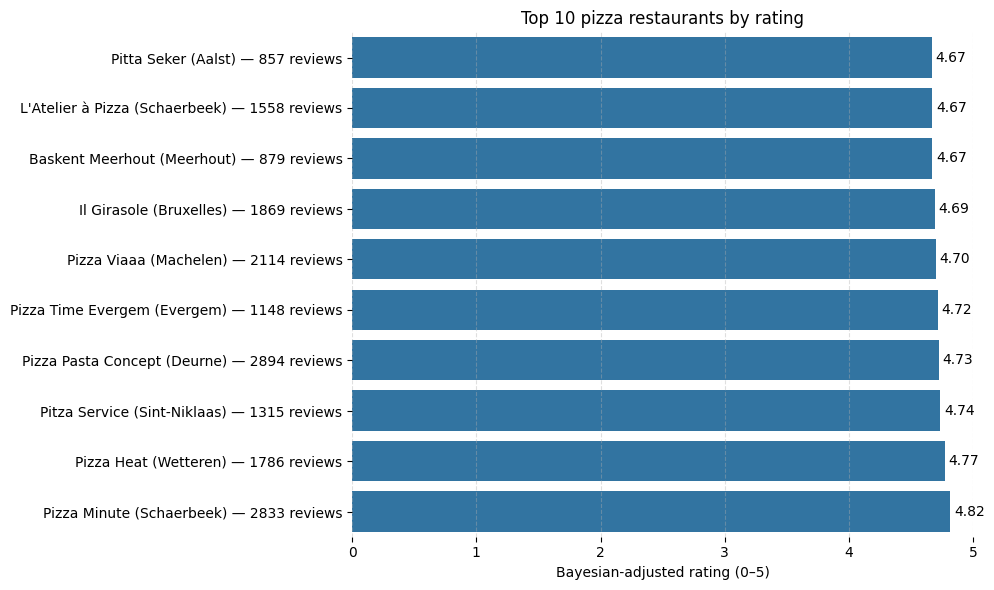

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# pick what you want to rank/plot (raw rating or bayes_rating)
score_col = "bayes_rating" if "bayes_rating" in top10_pizza.columns else "rating"

# ensure we have exactly 10 and sorted ascending for a nice horizontal chart
plot_df = (
    top10_pizza.sort_values(score_col, ascending=True)
              .head(10)
              .copy()
)

# Optional: build richer labels (city + review count)
plot_df["label"] = plot_df["restaurant"].astype(str)
if "city" in plot_df.columns:
    plot_df["label"] = plot_df["label"] + " (" + plot_df["city"].astype(str) + ")"
if "rating_count" in plot_df.columns:
    plot_df["label"] = plot_df["label"] + " — " + plot_df["rating_count"].astype(int).astype(str) + " reviews"

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x=score_col,
    y="label",
    orient="h"
)

# nicer scale + reference grid
ax.set_xlim(0, 5)
ax.set_xlabel("Rating (0–5)" if score_col == "rating" else "Bayesian-adjusted rating (0–5)")
ax.set_ylabel("")
ax.set_title("Top 10 pizza restaurants by rating")

# annotate values at the end of each bar
for p in ax.patches:
    val = p.get_width()
    ax.text(val + 0.03, p.get_y() + p.get_height()/2, f"{val:.2f}", va="center")

ax.grid(axis="x", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


## Raw vs Bayesian ranking

In [39]:
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# Settings (IMPORTANT)
# ----------------------------
MIN_PIZZA_ITEMS = 3  
MIN_REVIEWS_RAW = 0   
MIN_REVIEWS_BAYES = 0

# ----------------------------
# Text normalize + pizza detection
# ----------------------------
PIZZA_PATTERNS = [r"\bpizza\b", r"\bpizzas\b", r"\bpizzeria\b"]

def norm_text(s):
	if s is None:
		return ""
	s = str(s).lower()
	s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
	s = re.sub(r"[^a-z0-9\s]", " ", s)
	s = re.sub(r"\s+", " ", s).strip()
	return s

pizza_re = re.compile("|".join(PIZZA_PATTERNS))

def text_blob(row):
	a = row.get("item_name", "") or ""
	b = row.get("item_desc", "") or ""
	return f"{a} {b}"

df = df.copy()
df["blob"] = df.apply(text_blob, axis=1).map(norm_text)
df["is_pizza_item"] = df["blob"].str.contains(pizza_re, regex=True)

# Force numeric (handles commas too)
df["rating"] = pd.to_numeric(df["rating"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df["rating_count"] = pd.to_numeric(df["rating_count"].astype(str).str.replace(",", ".", regex=False), errors="coerce")

# Aggregate to restaurant level (DIRECTLY from df)
pizza_restaurants = (
	df[df["is_pizza_item"]]
	.groupby("primarySlug", as_index=False)
	.agg(
		restaurant=("restaurant", "first"),
		city=("city", "first"),
		rating=("rating", "max"),              # should be identical across items; max is safe
		rating_count=("rating_count", "max"),  # should be identical across items; max is safe
		pizza_items=("is_pizza_item", "sum"),
	)
)

pizza_restaurants = pizza_restaurants.dropna(subset=["rating","rating_count"])
pizza_restaurants = pizza_restaurants[pizza_restaurants["pizza_items"] >= MIN_PIZZA_ITEMS].copy()


In [40]:
# RAW Top 10 (intentionally allows low review counts)
raw_pool = pizza_restaurants[pizza_restaurants["rating_count"] >= MIN_REVIEWS_RAW].copy()

top10_raw = raw_pool.sort_values(
	["rating", "rating_count", "pizza_items"],
	ascending=[False, False, False]
).head(10).copy()

# Bayesian-adjusted rating
bayes_pool = pizza_restaurants[pizza_restaurants["rating_count"] >= MIN_REVIEWS_BAYES].copy()
C = bayes_pool["rating"].mean()
m = bayes_pool["rating_count"].median()

v = bayes_pool["rating_count"].astype(float)
R = bayes_pool["rating"].astype(float)
bayes_pool["bayes_rating"] = (v/(v+m))*R + (m/(v+m))*C

top10_bayes = bayes_pool.sort_values(
	["bayes_rating", "rating_count", "pizza_items"],
	ascending=[False, False, False]
).head(10).copy()


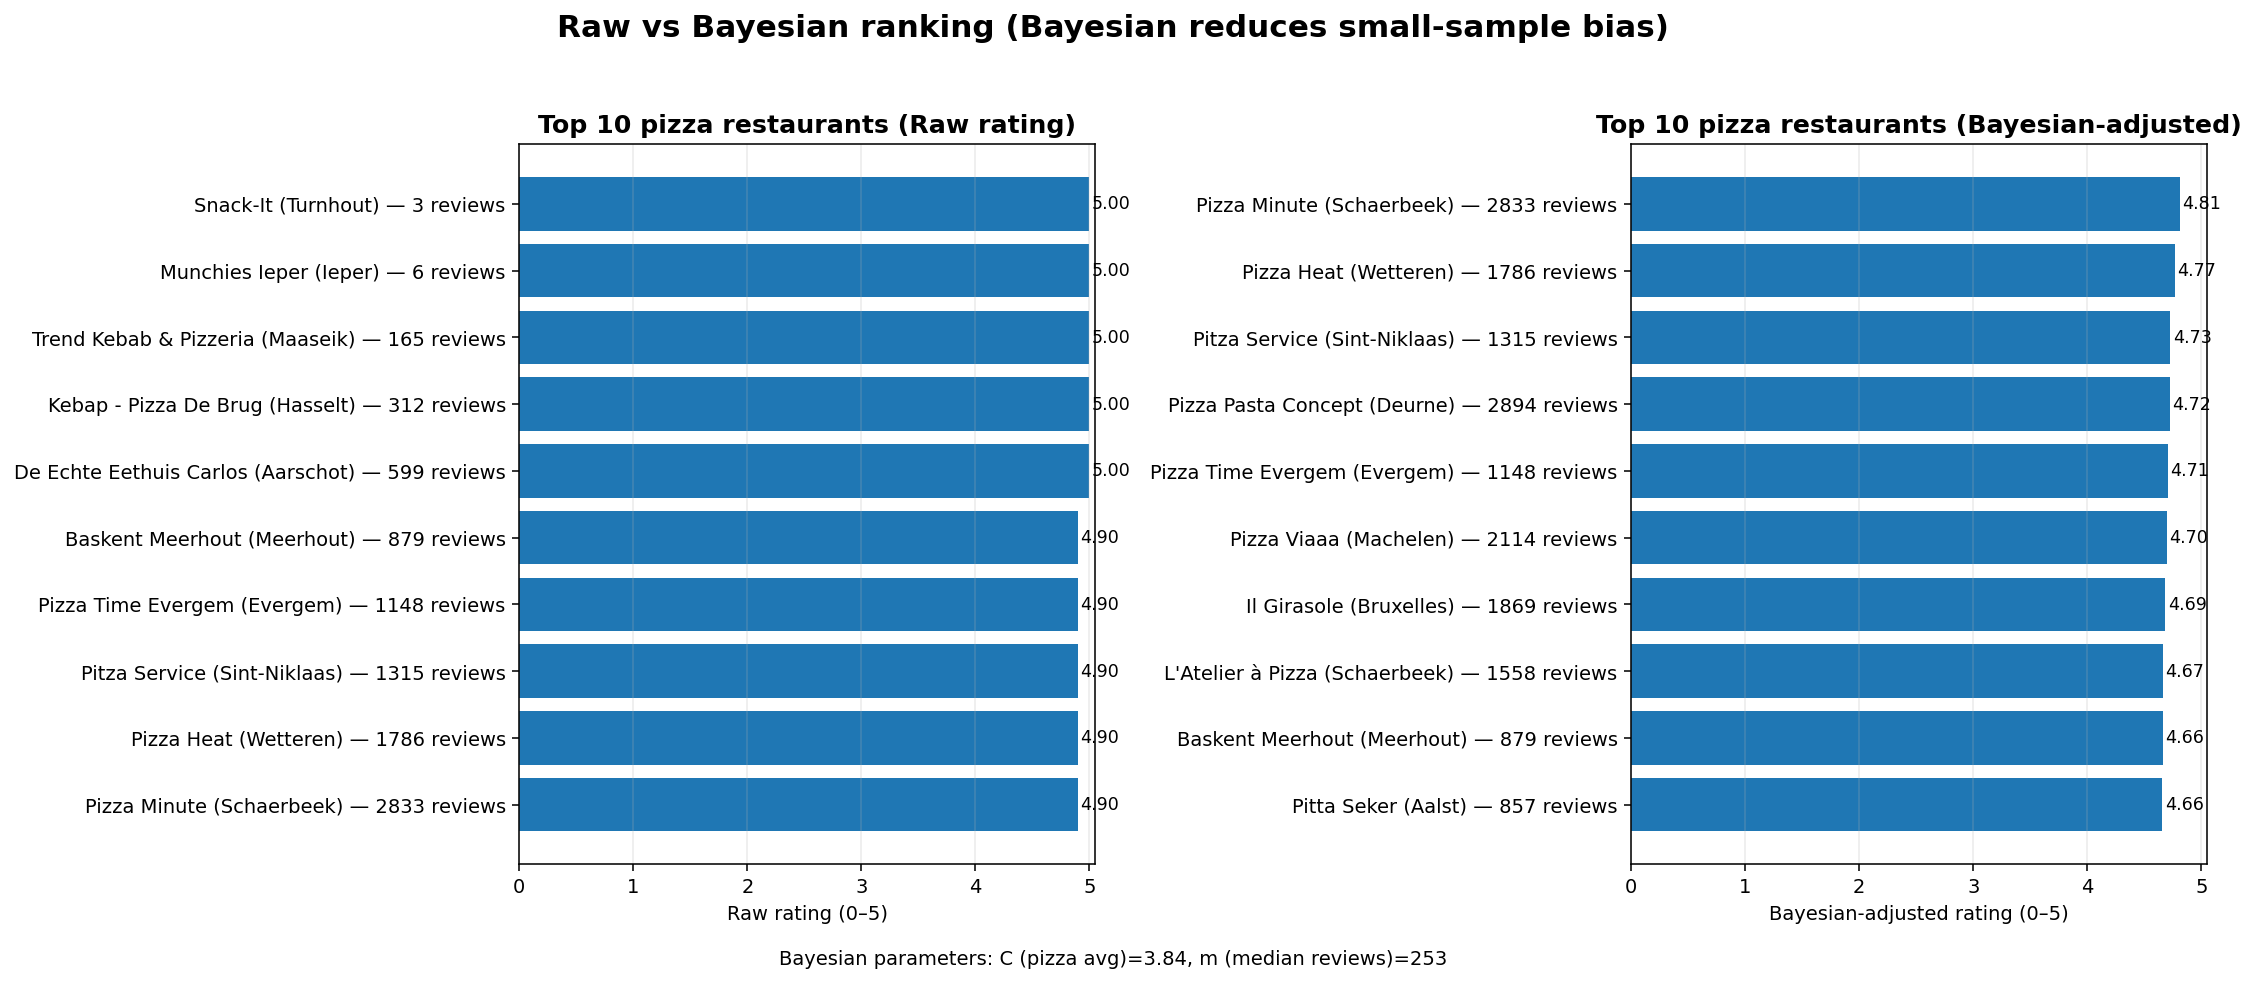

In [38]:
def _plot_barh(ax, d, value_col, title, xlabel):
	d = d.copy()
	d["label"] = (
		d["restaurant"].astype(str)
		+ " (" + d["city"].astype(str) + ")"
		+ " — " + d["rating_count"].astype(int).astype(str) + " reviews"
	)
	d = d.sort_values(value_col, ascending=True)

	ax.barh(d["label"], d[value_col].astype(float))
	ax.set_xlim(0, 5.05)
	ax.set_xlabel(xlabel)
	ax.set_title(title, fontsize=13, fontweight="bold")
	ax.grid(True, axis="x", alpha=0.25)
	ax.grid(False, axis="y")

	# value labels
	for y, v in enumerate(d[value_col].astype(float).values):
		ax.text(v + 0.02, y, f"{v:.2f}", va="center", fontsize=9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), dpi=140)

_plot_barh(ax1, top10_raw, "rating", "Top 10 pizza restaurants (Raw rating)", "Raw rating (0–5)")
_plot_barh(ax2, top10_bayes, "bayes_rating", "Top 10 pizza restaurants (Bayesian-adjusted)", "Bayesian-adjusted rating (0–5)")

# Small footer clarifying Bayesian parameters
fig.suptitle("Raw vs Bayesian ranking (Bayesian reduces small-sample bias)", fontsize=16, fontweight="bold", y=0.98)
fig.text(0.5, 0.01, f"Bayesian parameters: C (pizza avg)={C:.2f}, m (median reviews)={m:.0f}", ha="center", fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Insights :

1. Raw-rating Top 10 dominated by tiny samples. Several restaurants hit 5.00 with 3–6 reviews, which is statistically unstable.

2. Bayesian Top 10 rewards proven quality at scale. The winners have ~857–2,894 reviews and still maintain ~4.66–4.81 adjusted scores.

3. Bayesian weighting : low-review 5.0 entries are pulled toward the pizza-category baseline (C), so they drop out of the Top 10 once we adjust.

4. The ranking becomes more credible for consumers and partners : it balances rating with reliability (review volume).

5. C (pizza average rating) = 3.84 and m (median review count) = 253 : a restaurant with ~253 reviews is the “typical” case; below that, ratings get meaningfully shrunk toward 3.84.

6. Businness : 

    - Raw rating alone is not a safe KPI for leaderboards (it incentivizes small-sample “perfect scores”).

    - Bayesian ranking is a fairer partner benchmark: it highlights restaurants delivering consistently high experience across hundreds/thousands of orders.

    - Platform: Use Bayesian rating for “Top rated” lists to avoid misleading rankings and improve customer trust.

    - Restaurant partners: Sustainable visibility comes from consistent service at scale (more reviews + high rating), not just a few perfect scores.

# Q4: Map locations offering sushi + average price

## Assumptions

A restaurant “offers sushi” if at least one menu item matches sushi keywords in menuItems.name (optionally description).

We map restaurant coordinates (restaurants.latitude/longitude) as the location proxy.

menuItems.price is treated as EUR.

Average sushi price per restaurant = mean price of matched items.

## SQL extract

In [20]:
df_s = pd.read_sql("""
SELECT
  r.primarySlug,
  r.name          AS restaurant,
  r.city          AS city,
  r.latitude      AS lat,
  r.longitude     AS lon,
  r.ratings       AS rating,
  r.ratingsNumber AS rating_count,
  m.name          AS item_name,
  m.description   AS item_desc,
  m.price         AS price
FROM restaurants r
JOIN menuItems m
  ON m.primarySlug = r.primarySlug
WHERE r.latitude IS NOT NULL
  AND r.longitude IS NOT NULL
  AND m.price IS NOT NULL
""", con)

df_s["price_eur"] = df_s["price"].map(price_eur)
df_s = df_s.dropna(subset=["price_eur", "lat", "lon"])


## Keyword detection (sushi)

In [21]:
SUSHI_PATTERNS = [
    r"\bsushi\b",
    r"\bsashimi\b",
    r"\bmaki\b",
    r"\bnigiri\b",
    r"\buramaki\b",
    r"\btemaki\b",
]

df_s["blob"] = (df_s["item_name"].fillna("") + " " + df_s["item_desc"].fillna("")).map(norm_text)
df_s["is_sushi"] = df_s["blob"].apply(lambda t: contains_any(t, SUSHI_PATTERNS))

df_sushi = df_s[df_s["is_sushi"]].copy()
df_sushi.shape


(12187, 13)

## Average sushi price per restaurant

In [22]:
sushi_by_rest = (
    df_sushi.groupby(["primarySlug", "restaurant", "city", "lat", "lon"], as_index=False)
            .agg(
                sushi_items=("is_sushi", "sum"),
                avg_sushi_price=("price_eur", "mean"),
                min_sushi_price=("price_eur", "min"),
                max_sushi_price=("price_eur", "max"),
            )
)

sushi_by_rest = sushi_by_rest[sushi_by_rest["sushi_items"] >= 1].copy()
sushi_by_rest.sort_values("sushi_items", ascending=False).head(10)


primarySlug                   restaurant        city  \
181    osaka-sushi-antwerpen-1        Osaka Sushi Antwerpen   Antwerpen   
232  sushi-antwerpen-take-away  Sushi Antwerpen & Take away   Antwerpen   
3                        akira                        Akira      Tubize   
177                   om-sushi                     Om Sushi      Ekeren   
39               doragon-sushi                Doragon Sushi  Herenthout   
69         hoshi-hoshi-express          Hoshi Hoshi express    Vilvorde   
102                    kyoto-1                        Kyoto      Leuven   
324                 sushipoint                  Sushi Point  Roosendaal   
261             sushi-king-mol               Sushi King Mol         Mol   
265         sushi-king-zoersel           Sushi King Zoersel     Zoersel   

           lat       lon  sushi_items  avg_sushi_price  min_sushi_price  \
181  51.206015  4.396352          103        17.779515             3.00   
232  51.205870  4.396482           94        17.176596             3.00   
3    50.691683  4.203576           91         9.810989             2.00   
177  51.292243  4.443945           78        16.467949             3.00   
39   51.139892  4.759038           75        33.514667             8.20   
69   50.931052  4.422818           75        12.177333             2.00   
102  50.873652  4.713845           74        15.885135             4.00   
324  51.530875  4.458995           72        13.527083             3.95   
261  51.190006  5.117914           69        24.791304             7.20   
265  51.265859  4.637338           68        24.704412             7.20   

     max_sushi_price  
181            95.00  
232            95.00  
3              64.90  
177           150.00  
39            136.00  
69             85.00  
102           105.00  
324           119.95  
261           150.00  
265           150.00

## Sushi map

In [23]:
import folium

center = [sushi_by_rest["lat"].median(), sushi_by_rest["lon"].median()]
m_sushi = folium.Map(location=center, zoom_start=11)

for _, r in sushi_by_rest.iterrows():
    popup_html = (
        f"<b>{r['restaurant']}</b><br>"
        f"City: {r['city']}<br>"
        f"Sushi items: {int(r['sushi_items'])}<br>"
        f"Avg price: €{r['avg_sushi_price']:.2f}<br>"
        f"Min–Max: €{r['min_sushi_price']:.2f} – €{r['max_sushi_price']:.2f}"
    )
    folium.Marker(
        location=[r["lat"], r["lon"]],
        popup=folium.Popup(popup_html, max_width=320),
        tooltip=r["restaurant"],
        icon=folium.Icon(icon="cutlery", prefix="fa")  # pointer marker with an icon
    ).add_to(m_sushi)

m_sushi


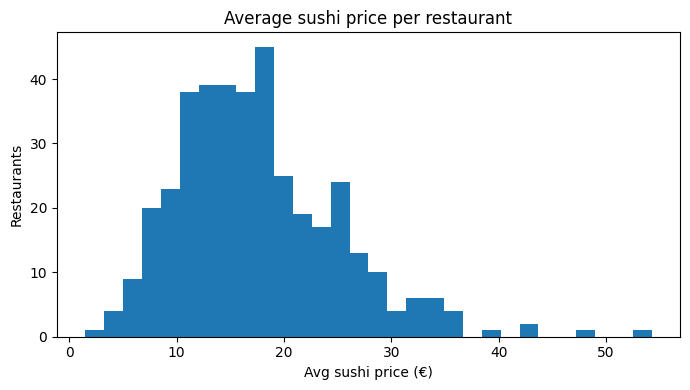

In [24]:
plt.figure(figsize=(7,4))
plt.hist(sushi_by_rest["avg_sushi_price"], bins=30)
plt.title("Average sushi price per restaurant")
plt.xlabel("Avg sushi price (€)")
plt.ylabel("Restaurants")
plt.tight_layout()
plt.show()


In [25]:
from pathlib import Path

out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)

html_path = out / "sushi_map.html"
m_sushi.save(str(html_path))
html_path


WindowsPath('report/maps/sushi_map.html')

# Q5 — Which restaurants have the best price-to-rating ratio?


## Assumptions:

- Price proxy = average menu item price per restaurant (from menuItems.price).

- Rating = restaurants.ratings with restaurants.ratingsNumber as confidence.

- To reduce noise, we require:

    ratingsNumber >= MIN_REVIEWS

    at least MIN_ITEMS priced menu items

- We use a Bayesian-adjusted rating (same idea as before) so tiny review counts don’t dominate.

Value score = bayes_rating / avg_item_price.

## SQL extract

In [26]:
df_val = pd.read_sql("""
SELECT
  r.primarySlug,
  r.name          AS restaurant,
  r.city          AS city,
  r.ratings       AS rating,
  r.ratingsNumber AS rating_count,
  m.price         AS price
FROM restaurants r
JOIN menuItems m
  ON m.primarySlug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND r.ratingsNumber IS NOT NULL
  AND m.price IS NOT NULL
""", con)

df_val["price_eur"] = df_val["price"].map(price_eur)
df_val = df_val.dropna(subset=["price_eur"])


## Aggregate to restaurant level

In [27]:
MIN_REVIEWS = 10
MIN_ITEMS = 5

rest = (
    df_val.groupby(["primarySlug", "restaurant", "city", "rating", "rating_count"], as_index=False)
          .agg(
              n_items=("price_eur", "size"),
              avg_item_price=("price_eur", "mean"),
              med_item_price=("price_eur", "median"),
          )
)

# Quality filters
rest = rest[
    (rest["rating_count"] >= MIN_REVIEWS) &
    (rest["n_items"] >= MIN_ITEMS) &
    (rest["avg_item_price"] > 0)
].copy()

rest.head(10)


primarySlug          restaurant        city  rating  \
0                  18-sushi            18 Sushi   Antwerpen     4.7   
1             2bangkok-thai       2Bangkok Thai        Gent     3.9   
3                3piramiden      De 3 Piramiden      Landen     3.6   
4                4-seizoene         4 Seizoenen  Brasschaat     4.7   
5                   5th-gok             5th Gok        Gent     3.9   
6                   7-seven         Snack Seven      Forest     3.4   
7           8tea5-antwerpen  8tea5 - Bubble Tea   Antwerpen     4.0   
8               8tea5-ghent  8tea5 - Bubble Tea        Gent     4.7   
9        a-la-turka-berchem  A La Turka Berchem   Antwerpen     4.4   
10  a-modo-mio-saint-gilles          A Modo Mio   Bruxelles     4.0   

    rating_count  n_items  avg_item_price  med_item_price  
0            420       99       10.668687            7.50  
1            203       61       17.114754           18.50  
3            163      121       10.950413           12.00  
4            522      132       13.344697           13.75  
5             34       48       24.000000           19.50  
6             60       86        4.316279            3.00  
7             77       45        6.677778            5.90  
8            111       55        5.852727            6.10  
9            110       82        4.289024            3.00  
10            41       54       14.129630           14.00

## Bayesian-adjusted rating + value score

In [28]:
# Use the candidate pool mean as baseline (more consistent than all restaurants)
C = float(rest["rating"].mean())
m = float(rest["rating_count"].median())  # prior strength

rest["bayes_rating"] = (
    (rest["rating_count"] / (rest["rating_count"] + m)) * rest["rating"]
    + (m / (rest["rating_count"] + m)) * C
)

# Value score (higher = better value)
rest["value_score"] = rest["bayes_rating"] / rest["avg_item_price"]

best_value = rest.sort_values(
    ["value_score", "bayes_rating", "rating_count"],
    ascending=[False, False, False]
).head(20)

best_value[["restaurant", "city", "avg_item_price", "bayes_rating", "rating", "rating_count", "value_score"]]


restaurant                  city  avg_item_price  \
955          El Bocadillos             Bruxelles        2.000000   
378      Boulangerie Salam  Molenbeek-Saint-Jean        2.039535   
85          Frituur Amigos               Wilrijk        2.411765   
256       Bazi Boulangerie            Anderlecht        2.335294   
3492          Street'Tacos               Waregem        2.382353   
2399              Palashop            Schaerbeek        2.408730   
1119         Frituur 4 You              Vilvorde        2.690471   
3025              QueTacos          Maasmechelen        2.857143   
1689       La Friterie Red            Anderlecht        2.581081   
1191       Frituur Permeke               Wilrijk        2.903279   
3199             Say Pasta             Antwerpen        2.712609   
1211      Frituur 't Koxke             Antwerpen        2.752869   
1118          Frituur 2010             Antwerpen        2.774359   
1212  Frituur 't Krokantje      Sint-Gillis-Waas        2.777778   
1197          Frituur Roma            Borgerhout        3.097701   
4053    Frituur chef Bruno                Weelde        2.807143   
1218  frituur 't viaductje             Antwerpen        2.786250   
1189  Frituur op't Hoekske             Vilvoorde        2.861000   
895         Dunkin' Donuts                  Gent        2.937037   
1656         La Bicyclette                Deinze        2.882609   

      bayes_rating  rating  rating_count  value_score  
955       4.163238     4.2           307     2.081619  
378       4.094684     4.1            21     2.007656  
85        4.274848     4.3          1172     1.772498  
256       4.105907     4.3            10     1.758197  
3492      4.050580     3.9            47     1.700244  
2399      4.075677     3.9            17     1.692044  
1119      4.442094     4.7           220     1.651047  
3025      4.538506     5.0           157     1.588477  
1689      4.098601     4.1           536     1.587940  
1191      4.528155     4.6           985     1.559669  
3199      4.228477     4.6            59     1.558823  
1211      4.247452     4.3           476     1.542918  
1118      4.203511     4.3           185     1.515129  
1212      4.178142     4.9            19     1.504131  
1197      4.621667     4.7          1098     1.491967  
4053      4.119666     4.5            11     1.467566  
1218      4.059037     3.8            22     1.456810  
1189      4.165660     5.0            14     1.456016  
895       4.266155     4.5           120     1.452537  
1656      4.150350     4.2           185     1.439790

In [29]:
best_value[["restaurant",  "value_score"]]

restaurant  value_score
955          El Bocadillos     2.081619
378      Boulangerie Salam     2.007656
85          Frituur Amigos     1.772498
256       Bazi Boulangerie     1.758197
3492          Street'Tacos     1.700244
2399              Palashop     1.692044
1119         Frituur 4 You     1.651047
3025              QueTacos     1.588477
1689       La Friterie Red     1.587940
1191       Frituur Permeke     1.559669
3199             Say Pasta     1.558823
1211      Frituur 't Koxke     1.542918
1118          Frituur 2010     1.515129
1212  Frituur 't Krokantje     1.504131
1197          Frituur Roma     1.491967
4053    Frituur chef Bruno     1.467566
1218  frituur 't viaductje     1.456810
1189  Frituur op't Hoekske     1.456016
895         Dunkin' Donuts     1.452537
1656         La Bicyclette     1.439790

## Result to be “value meals” not “cheap snacks”

In [30]:
# By using median instead of average item price
C = float(rest["rating"].mean())
m = float(rest["rating_count"].median())  # prior strength

rest["bayes_rating"] = (
    (rest["rating_count"] / (rest["rating_count"] + m)) * rest["rating"]
    + (m / (rest["rating_count"] + m)) * C
)

# Value score (higher = better value)
rest["value_score"] = rest["bayes_rating"] / rest["med_item_price"]

best_value = rest.sort_values(
    ["value_score", "bayes_rating", "rating_count"],
    ascending=[False, False, False]
).head(20)

best_value[["restaurant",  "value_score"]]

restaurant  value_score
256      Bazi Boulangerie     2.737271
2956          Plein Nr 12     2.428796
378     Boulangerie Salam     2.274825
1972               Makaio     2.234874
1944  Madagascar Pokébowl     2.183707
3716      Tekince Tantuni     2.156247
85         Frituur Amigos     2.137424
1971               Makaio     2.119127
982     Emirdağ Koftecisi     2.082830
955         El Bocadillos     2.081619
3169        Samy's Coffee     2.067777
2967         Poké For You     2.049550
981               Emirdağ     2.047910
3017               Qebaba     2.047356
86                Amino's     2.047298
3492         Street'Tacos     2.025290
1787          Le Familial     2.007180
2986          Potala Momo     1.993300
3951              Wazawok     1.990810
626         Crée Ta Crêpe     1.985290

In [31]:
# By Multiply by a menu-size factor:
C = float(rest["rating"].mean())
m = float(rest["rating_count"].median())  # prior strength

rest["bayes_rating"] = (
    (rest["rating_count"] / (rest["rating_count"] + m)) * rest["rating"]
    + (m / (rest["rating_count"] + m)) * C
)

# Value score (higher = better value)
rest["value_score"] = rest["bayes_rating"] / rest["med_item_price"]
rest["value_score"] = rest["value_score"] * np.log1p(rest["n_items"])

best_value = rest.sort_values(
    ["value_score", "bayes_rating", "rating_count"],
    ascending=[False, False, False]
).head(20)

best_value[["restaurant",  "value_score"]]

restaurant  value_score
85           Frituur Amigos    10.232899
378       Boulangerie Salam     8.608368
1212   Frituur 't Krokantje     7.997501
256        Bazi Boulangerie     7.911732
953   Ekoshop & Foodstation     7.882025
3952                Wazawok     7.821431
1191        Frituur Permeke     7.782256
4053     Frituur chef Bruno     7.603371
525           Cheat Burgers     7.587420
1129          Frituur Cindy     7.571573
2399               Palashop     7.533451
3169          Samy's Coffee     7.409918
1197           Frituur Roma     7.390271
1119          Frituur 4 You     7.328381
3492           Street'Tacos     7.200612
3836          TotalEnergies     7.180654
1089             Friendzone     7.121073
1656          La Bicyclette     7.101983
3017                 Qebaba     7.095597
356                 Bollero     7.054875

# Q6: Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

In [47]:
df_cov = pd.read_sql("""
SELECT
  l.postalCode AS postal_code,
  COUNT(DISTINCT lr.restaurant_id) AS n_restaurants
FROM locations_to_restaurants lr
JOIN locations l
  ON CAST(l.ID AS TEXT) = CAST(lr.location_id AS TEXT)
WHERE l.postalCode IS NOT NULL
GROUP BY l.postalCode
""", con)

df_cov["postal_code"] = df_cov["postal_code"].astype(str).str.strip()
df_cov = df_cov[~df_cov["postal_code"].str.contains(r"[A-Za-z]", regex=True)]
df_cov.head()


postal_code  n_restaurants
0        1140            605
1        1320              8
2        1500             56
3        1501             44
4        1502             46

In [66]:
DEAD_THRESHOLD = 10  # tune: 3, 5, 10 depending on how strict you want

dead_zones = df_cov[df_cov["n_restaurants"] <= DEAD_THRESHOLD].copy()
dead_zones = dead_zones.sort_values(["n_restaurants", "postal_code"], ascending=[True, True])

share_dead = len(dead_zones) / len(df_cov)
dead_summary = {
    "postal_codes_total": int(len(df_cov)),
    "dead_zones_postal_codes": int(len(dead_zones)),
    "dead_zone_share": float(share_dead),
    "threshold": DEAD_THRESHOLD
}

df_geo_pc = pd.read_sql("""
SELECT
  postalCode AS postal_code,
  latitude   AS lat,
  longitude  AS lon
FROM locations
WHERE postalCode IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
""", con)

df_geo_pc["postal_code"] = df_geo_pc["postal_code"].astype(str).str.strip()
df_geo_pc["lat"] = pd.to_numeric(df_geo_pc["lat"], errors="coerce")
df_geo_pc["lon"] = pd.to_numeric(df_geo_pc["lon"], errors="coerce")
df_geo_pc = df_geo_pc.dropna(subset=["lat","lon"])

geo_pc = (
    df_geo_pc.groupby("postal_code", as_index=False)
             .agg(lat=("lat","mean"), lon=("lon","mean"))
)

dead_map = dead_zones.merge(geo_pc, on="postal_code", how="inner")

In [67]:
import folium
from folium.plugins import MarkerCluster

center = [dead_map["lat"].median(), dead_map["lon"].median()]
map_dead = folium.Map(location=center, zoom_start=9, tiles="cartodbpositron")

cluster = MarkerCluster(name=f"Dead zones (≤{DEAD_THRESHOLD} restaurants)")

for _, r in dead_map.iterrows():
    folium.Marker(
        location=[r["lat"], r["lon"]],
        tooltip=f"{r['postal_code']} — {int(r['n_restaurants'])} restaurants",
        popup=folium.Popup(
            f"<b>Postal code:</b> {r['postal_code']}<br>"
            f"<b>Restaurants delivering:</b> {int(r['n_restaurants'])}",
            max_width=250
        ),
        icon=folium.Icon(icon="exclamation-triangle", prefix="fa")
    ).add_to(cluster)

cluster.add_to(map_dead)
folium.LayerControl(collapsed=False).add_to(map_dead)

out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)

html_path = out / "dead_zone1.html"
map_dead.save(str(html_path))
html_path



WindowsPath('report/maps/dead_zone1.html')

In [71]:
import folium
from folium.plugins import MarkerCluster
from pathlib import Path
from branca.element import MacroElement, Template

# ----------------------------
# CONFIG
# ----------------------------
THRESHOLDS = [3, 5, 10]
DEFAULT_T = 5

# ----------------------------
# MAP
# ----------------------------
center = [dead_map["lat"].median(), dead_map["lon"].median()]
map_dead = folium.Map(location=center, zoom_start=9, tiles="cartodbpositron")

# Build 3 FeatureGroups (we will toggle them via custom radio buttons)
fg_by_t = {}

for t in THRESHOLDS:
    fg = folium.FeatureGroup(name=f"dead_{t}", show=(t == DEFAULT_T))
    cluster = MarkerCluster()

    subset = dead_map[dead_map["n_restaurants"] <= t]
    for _, r in subset.iterrows():
        folium.Marker(
            location=[r["lat"], r["lon"]],
            tooltip=f"{r['postal_code']} — {int(r['n_restaurants'])} restaurants",
            popup=folium.Popup(
                f"<b>Postal code:</b> {r['postal_code']}<br>"
                f"<b>Restaurants delivering:</b> {int(r['n_restaurants'])}",
                max_width=250,
            ),
            icon=folium.Icon(icon="exclamation-triangle", prefix="fa"),
        ).add_to(cluster)

    cluster.add_to(fg)
    fg.add_to(map_dead)
    fg_by_t[t] = fg

# IMPORTANT: do NOT add folium.LayerControl() -> removes checkbox UI


# ----------------------------
# RADIO BUTTON CONTROL
# ----------------------------
class DeadThresholdRadio(MacroElement):
    def __init__(self, thresholds, default_t, fg_by_t, position="topright"):
        super().__init__()
        self._name = "DeadThresholdRadio"
        t2layer = {t: fg_by_t[t].get_name() for t in thresholds}

        self._template = Template(f"""
{{% macro script(this, kwargs) %}}
(function() {{
  var map = {map_dead.get_name()};
  var thresholds = {thresholds};
  var t2layer = {{
    {", ".join([f"{t}: {t2layer[t]}" for t in thresholds])}
  }};

  function setThreshold(t) {{
    thresholds.forEach(function(tt) {{
      if (map.hasLayer(t2layer[tt])) map.removeLayer(t2layer[tt]);
    }});
    map.addLayer(t2layer[t]);

    var label = document.getElementById('dead-threshold-label');
    if (label) label.innerHTML = "Dead zones threshold: ≤" + t + " restaurants";
  }}

  var control = L.control({{position: '{position}'}});
  control.onAdd = function(map) {{
    var div = L.DomUtil.create('div', 'leaflet-bar');
    div.style.background = 'white';
    div.style.padding = '10px';
    div.style.minWidth = '240px';
    div.style.boxShadow = '0 1px 4px rgba(0,0,0,0.2)';

    div.innerHTML = `
      <div id="dead-threshold-label" style="font-size:14px; font-weight:600; margin-bottom:8px;">
        Dead zones threshold: ≤{default_t} restaurants
      </div>

      <div style="display:flex; gap:10px; align-items:center;">
        {''.join([
          f'''
          <label style="display:flex; gap:6px; align-items:center; cursor:pointer; font-size:13px;">
            <input type="radio" name="deadthr" value="{t}" {'checked' if t==default_t else ''}/>
            ≤{t}
          </label>
          ''' for t in thresholds
        ])}
      </div>
    `;

    L.DomEvent.disableClickPropagation(div);
    return div;
  }};
  control.addTo(map);

  // wire events
  document.querySelectorAll("input[name='deadthr']").forEach(function(el) {{
    el.addEventListener('change', function(e) {{
      setThreshold(parseInt(e.target.value, 10));
    }});
  }});

  // ensure correct layer on load
  setThreshold({default_t});
}})();
{{% endmacro %}}
""")

map_dead.get_root().add_child(DeadThresholdRadio(THRESHOLDS, DEFAULT_T, fg_by_t))

# ----------------------------
# SAVE
# ----------------------------
out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)

html_path = out / "dead_zone_multiple.html"
map_dead.save(str(html_path))
html_path


WindowsPath('report/maps/dead_zone_multiple.html')

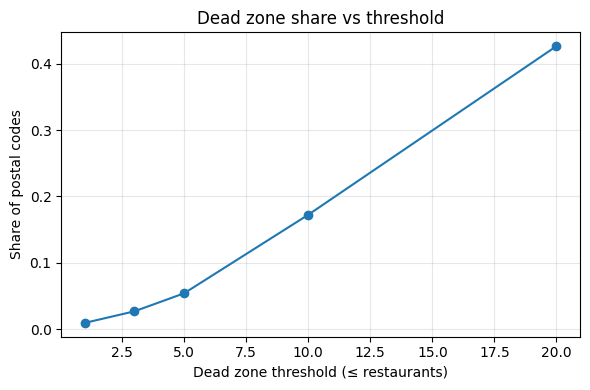

threshold  dead_postal_codes     share
0          1                  5  0.009690
1          3                 14  0.027132
2          5                 28  0.054264
3         10                 89  0.172481
4         20                220  0.426357

In [38]:
thresholds = [1, 3, 5, 10, 20]
rows = []
for t in thresholds:
    rows.append({
        "threshold": t,
        "dead_postal_codes": int((df_cov["n_restaurants"] <= t).sum()),
        "share": float((df_cov["n_restaurants"] <= t).mean())
    })

df_dead_sens = pd.DataFrame(rows)

plt.figure(figsize=(6,4))
plt.plot(df_dead_sens["threshold"], df_dead_sens["share"], marker="o")
plt.xlabel("Dead zone threshold (≤ restaurants)")
plt.ylabel("Share of postal codes")
plt.title("Dead zone share vs threshold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_dead_sens


# Q7: How does the availability of vegetarian and vegan dishes vary by area?

In [72]:
df_items = pd.read_sql("""
SELECT
  r.primarySlug,
  r.city AS city,
  m.name AS item_name,
  m.description AS item_desc
FROM restaurants r
JOIN menuItems m
  ON m.primarySlug = r.primarySlug
WHERE r.city IS NOT NULL
  AND (m.name IS NOT NULL OR m.description IS NOT NULL)
""", con)

df_items["city_clean"] = df_items["city"].astype(str).str.strip().str.lower()


In [73]:
VEG_PATTERNS = [
    r"\bvegetarian\b", r"\bveggie\b", r"\bveg\b", r"\bmeatless\b",
    r"\bvegetarisch\b",          # NL
    r"\bv[eé]g[eé]tarien(ne)?\b" # FR
]

VEGAN_PATTERNS = [
    r"\bvegan\b", r"\bplant[- ]based\b",
    r"\bveganistisch\b",         # NL
    r"\bv[eé]gan(e)?\b"          # FR
]

df_items["blob"] = (df_items["item_name"].fillna("") ).map(norm_text)
df_items["is_veg_item"] = df_items["blob"].apply(lambda t: contains_any(t, VEG_PATTERNS))
df_items["is_vegan_item"] = df_items["blob"].apply(lambda t: contains_any(t, VEGAN_PATTERNS))


In [74]:
rest_flags = (
    df_items.groupby(["primarySlug", "city_clean"], as_index=False)
    .agg(
        veg_items=("is_veg_item", "sum"),
        vegan_items=("is_vegan_item", "sum"),
    )
)

rest_flags["offers_veg"] = rest_flags["veg_items"] > 0
rest_flags["offers_vegan"] = rest_flags["vegan_items"] > 0

rest_flags.head()


primarySlug  city_clean  veg_items  vegan_items  offers_veg  \
0          18-sushi   antwerpen          2            0        True   
1     2bangkok-thai        gent          1            0        True   
2  2taste-antwerpen   antwerpen          0            0       False   
3        3piramiden      landen          1            0        True   
4        4-seizoene  brasschaat          5            0        True   

   offers_vegan  
0         False  
1         False  
2         False  
3         False  
4         False

In [75]:
city_stats = (
    rest_flags.groupby("city_clean", as_index=False)
    .agg(
        restaurants=("primarySlug", "nunique"),
        veg_restaurants=("offers_veg", "sum"),
        vegan_restaurants=("offers_vegan", "sum"),
        total_veg_items=("veg_items", "sum"),
        total_vegan_items=("vegan_items", "sum"),
    )
)

city_stats["veg_share"] = city_stats["veg_restaurants"] / city_stats["restaurants"]
city_stats["vegan_share"] = city_stats["vegan_restaurants"] / city_stats["restaurants"]

# reduce noise (tune threshold)
MIN_RESTS_PER_CITY = 10
city_stats = city_stats[city_stats["restaurants"] >= MIN_RESTS_PER_CITY].copy()

city_stats.sort_values("vegan_share", ascending=False).head(20)


city_clean  restaurants  veg_restaurants  vegan_restaurants  \
23          asse           12                7                  3   
206        ieper           12               10                  3   
291     mechelen           83               40                 17   
303          mol           10                8                  2   
182    herentals           10                7                  2   
94        deinze           10                4                  2   
74        brugge           92               52                 18   
144         gent          306              175                 58   
505     zaventem           16                5                  3   
239     kortrijk           16               10                  3   
2          aalst           38               21                  7   
446       tubize           11                6                  2   
167        hamme           11                7                  2   
263       leuven          173               91                 29   
141         geel           12               10                  2   
274      lokeren           12                9                  2   
276       lommel           12               11                  2   
97   dendermonde           12                6                  2   
224    kessel-lo           12                6                  2   
27     auderghem           12                6                  2   

     total_veg_items  total_vegan_items  veg_share  vegan_share  
23                23                 11   0.583333     0.250000  
206               29                  6   0.833333     0.250000  
291              130                 37   0.481928     0.204819  
303               50                  5   0.800000     0.200000  
182               38                  7   0.700000     0.200000  
94                30                 19   0.400000     0.200000  
74               193                 50   0.565217     0.195652  
144              747                218   0.571895     0.189542  
505               16                  8   0.312500     0.187500  
239               21                  9   0.625000     0.187500  
2                 95                 21   0.552632     0.184211  
446                9                  5   0.545455     0.181818  
167               44                  9   0.636364     0.181818  
263              379                 73   0.526012     0.167630  
141               58                  5   0.833333     0.166667  
274               30                 12   0.750000     0.166667  
276               67                  5   0.916667     0.166667  
97                30                  6   0.500000     0.166667  
224               26                  6   0.500000     0.166667  
27                11                  6   0.500000     0.166667

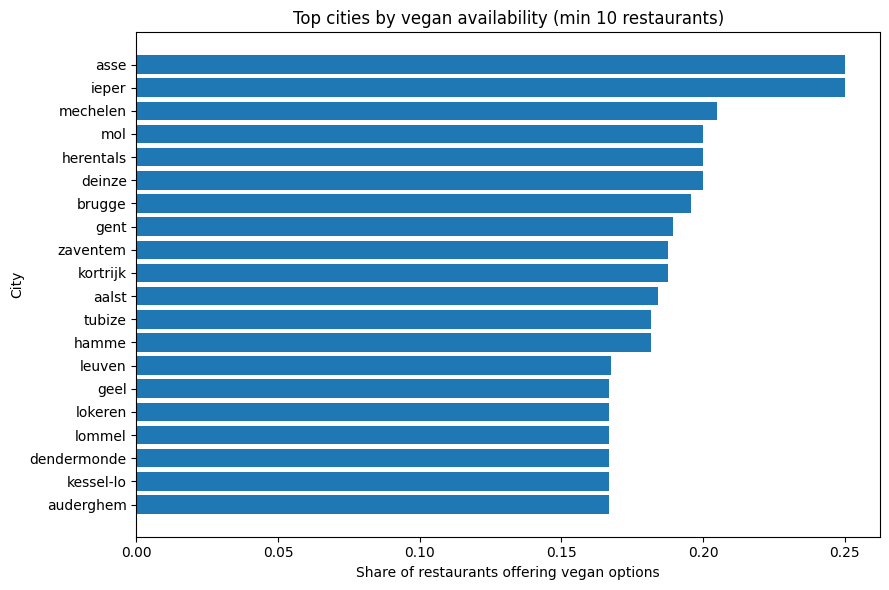

In [76]:
top = city_stats.sort_values("vegan_share", ascending=False).head(20)

plt.figure(figsize=(9, 6))
plt.barh(top["city_clean"][::-1], top["vegan_share"][::-1])
plt.xlabel("Share of restaurants offering vegan options")
plt.ylabel("City")
plt.title(f"Top cities by vegan availability (min {MIN_RESTS_PER_CITY} restaurants)")
plt.tight_layout()
plt.show()


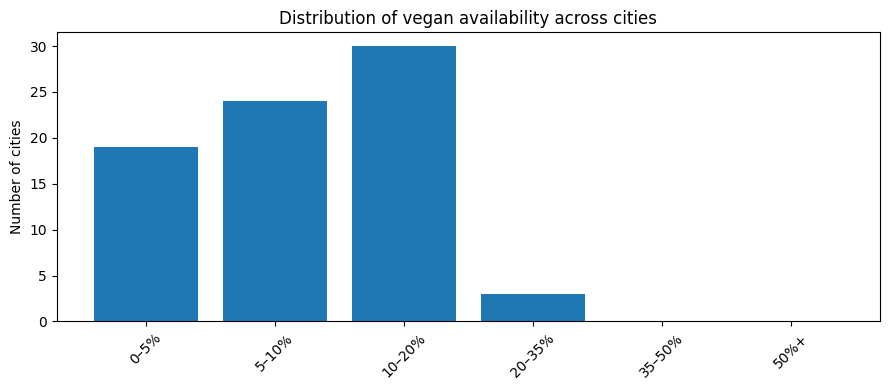

In [77]:
bins = [0, .05, .10, .20, .35, .50, 1.0]
labels = ["0–5%", "5–10%", "10–20%", "20–35%", "35–50%", "50%+"]

city_stats["vegan_bucket"] = pd.cut(city_stats["vegan_share"], bins=bins, labels=labels, include_lowest=True)
bucket = city_stats["vegan_bucket"].value_counts().sort_index()

plt.figure(figsize=(9, 4))
plt.bar(bucket.index.astype(str), bucket.values)
plt.ylabel("Number of cities")
plt.title("Distribution of vegan availability across cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import h3
import re, unicodedata

def norm_text(x):
    if x is None:
        return ""
    x = str(x).lower().strip()
    x = unicodedata.normalize("NFKD", x)
    x = "".join(c for c in x if not unicodedata.combining(c))
    x = re.sub(r"[^\w\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def contains_any(text, patterns):
    if not text:
        return False
    return any(re.search(p, text) for p in patterns)

VEG_PATTERNS = [
    r"\bvegetarian\b", r"\bveggie\b", r"\bveg\b", r"\bmeatless\b",
    r"\bvegetarisch\b",
    r"\bv[eé]g[eé]tarien(ne)?\b"
]
VEGAN_PATTERNS = [
    r"\bvegan\b", r"\bplant[- ]based\b",
    r"\bveganistisch\b",
    r"\bv[eé]gan(e)?\b"
]

df_items = pd.read_sql("""
SELECT
  primarySlug,
  name AS item_name,
  description AS item_desc
FROM menuItems
WHERE primarySlug IS NOT NULL
  AND (name IS NOT NULL OR description IS NOT NULL)
""", con)

df_items["blob"] = (df_items["item_name"].fillna("") + " " + df_items["item_desc"].fillna("")).map(norm_text)
df_items["is_veg_item"] = df_items["blob"].apply(lambda t: contains_any(t, VEG_PATTERNS))
df_items["is_vegan_item"] = df_items["blob"].apply(lambda t: contains_any(t, VEGAN_PATTERNS))

rest_flags = (
    df_items.groupby("primarySlug", as_index=False)
    .agg(
        veg_items=("is_veg_item", "sum"),
        vegan_items=("is_vegan_item", "sum"),
    )
)
rest_flags["offers_veg"] = rest_flags["veg_items"] > 0
rest_flags["offers_vegan"] = rest_flags["vegan_items"] > 0

rest_flags.head()


primarySlug  veg_items  vegan_items  offers_veg  offers_vegan
0          18-sushi          2            0        True         False
1     2bangkok-thai          3            0        True         False
2  2taste-antwerpen          0            0       False         False
3        3piramiden          1            0        True         False
4        4-seizoene          5            0        True         False

In [79]:
df_geo = pd.read_sql("""
SELECT
  primarySlug,
  latitude AS lat,
  longitude AS lon,
  name AS restaurant,
  city
FROM restaurants
WHERE primarySlug IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
""", con)

df_rest = df_geo.merge(rest_flags, on="primarySlug", how="left")
df_rest["offers_vegan"] = df_rest["offers_vegan"].fillna(False)
df_rest["offers_veg"] = df_rest["offers_veg"].fillna(False)

# Clean lat/lon
df_rest["lat"] = pd.to_numeric(df_rest["lat"], errors="coerce")
df_rest["lon"] = pd.to_numeric(df_rest["lon"], errors="coerce")
df_rest = df_rest.dropna(subset=["lat", "lon"])

df_rest.shape, df_rest.head()


((4071, 9),
                 primarySlug        lat       lon              restaurant  \
 0                pasta-pino  50.743630  3.216888              Pasta Pino   
 1         da-barone-et-fils  50.540992  5.460752       Da Barone et Fils   
 2             pizza-gustosa  50.675491  5.480206           Pizza Gustosa   
 3  la-brezza-nova-rocourt-1  50.684180  5.549703  La Brezza Nova Rocourt   
 4             la-storia-ans  50.663340  5.512421               La Storia   
 
        city  veg_items  vegan_items  offers_veg  offers_vegan  
 0  Mouscron        0.0          0.0       False         False  
 1    Neupré        1.0          0.0        True         False  
 2     Awans        3.0          0.0        True         False  
 3     Liège        1.0          0.0        True         False  
 4     Liège        1.0          0.0        True         False  )

In [80]:
H3_RES = 8

df_rest["h3"] = df_rest.apply(lambda r: h3.latlng_to_cell(r["lat"], r["lon"], H3_RES), axis=1)

In [81]:
cell_stats = (
    df_rest.groupby("h3", as_index=False)
    .agg(
        restaurants=("primarySlug", "nunique"),
        vegan_restaurants=("offers_vegan", "sum"),
        veg_restaurants=("offers_veg", "sum"),
        lat=("lat", "mean"),
        lon=("lon", "mean")
    )
)

cell_stats["vegan_share"] = cell_stats["vegan_restaurants"] / cell_stats["restaurants"]
cell_stats["veg_share"] = cell_stats["veg_restaurants"] / cell_stats["restaurants"]

# Filter tiny-sample cells to reduce noise
MIN_RESTS_PER_CELL = 3
cell_stats = cell_stats[cell_stats["restaurants"] >= MIN_RESTS_PER_CELL].copy()

cell_stats.sort_values("vegan_share", ascending=False).head(10)

h3  restaurants  vegan_restaurants  veg_restaurants  \
753   881fa44563fffff            4                  3                1   
310   881fa08155fffff            3                  2                1   
90    88194d395bfffff            3                  2                1   
583   881fa42a09fffff            3                  2                1   
938   881fa45a91fffff            5                  3                1   
301   88194dccb5fffff            7                  4                7   
897   881fa4548dfffff            7                  4                5   
1026  881fa48d9bfffff            4                  2                2   
520   881fa41a65fffff            4                  2                3   
96    88194d3a07fffff            4                  2                2   

            lat       lon  vegan_share  veg_share  
753   50.880275  4.473517     0.750000   0.250000  
310   50.781697  5.465889     0.666667   0.333333  
90    50.808786  3.182783     0.666667   0.333333  
583   51.078954  5.218973     0.666667   0.333333  
938   50.911971  4.194992     0.600000   0.200000  
301   51.230202  2.911203     0.571429   1.000000  
897   51.028102  4.489160     0.571429   0.714286  
1026  51.398305  4.758032     0.500000   0.500000  
520   51.200391  4.441518     0.500000   0.750000  
96    50.827317  3.264595     0.500000   0.500000

In [82]:
def h3_to_geojson_feature(h, value, props=None):
    # h3.cell_to_boundary returns (lat, lon) pairs
    boundary = h3.cell_to_boundary(h)
    # GeoJSON wants (lon, lat)
    coords = [(lng, lat) for (lat, lng) in boundary]
    # close polygon
    coords.append(coords[0])

    feature = {
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": [coords]},
        "properties": {"h3": h, "value": float(value)}
    }
    if props:
        feature["properties"].update(props)
    return feature

# Choose which metric to map
metric = "vegan_share"   # or "veg_share" or "restaurants"

vmin, vmax = float(cell_stats[metric].min()), float(cell_stats[metric].max())
colormap = cm.linear.YlGnBu_09.scale(vmin, vmax)
colormap.caption = f"H3 {metric} (res={H3_RES}, min cell restaurants={MIN_RESTS_PER_CELL})"

features = []
for _, r in cell_stats.iterrows():
    props = {
        "restaurants": int(r["restaurants"]),
        "vegan_restaurants": int(r["vegan_restaurants"]),
        "vegan_share": float(r["vegan_share"]),
        "veg_restaurants": int(r["veg_restaurants"]),
        "veg_share": float(r["veg_share"]),
    }
    features.append(h3_to_geojson_feature(r["h3"], r[metric], props=props))

geojson = {"type": "FeatureCollection", "features": features}

center = [float(df_rest["lat"].median()), float(df_rest["lon"].median())]
m_h3 = folium.Map(location=center, zoom_start=9, tiles="cartodbpositron")

def style_fn(feat):
    v = feat["properties"]["value"]
    return {
        "fillColor": colormap(v),
        "color": "#444444",
        "weight": 0.5,
        "fillOpacity": 0.65,
    }

tooltip = folium.GeoJsonTooltip(
    fields=["restaurants", "vegan_restaurants", "vegan_share", "veg_restaurants", "veg_share"],
    aliases=["Restaurants", "Vegan restaurants", "Vegan share", "Veg restaurants", "Veg share"],
    localize=True
)

folium.GeoJson(geojson, style_function=style_fn, tooltip=tooltip).add_to(m_h3)
colormap.add_to(m_h3)

m_h3

In [83]:
from pathlib import Path
out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)
path = out / f"h3_{metric}_res{H3_RES}.html"
m_h3.save(str(path))
path

WindowsPath('report/maps/h3_vegan_share_res8.html')

In [71]:
# Add a second layer: vegan restaurant markers on top of the H3 choropleth
# Assumes you already created: m_h3 (folium.Map) and df_rest with lat/lon/restaurant/offers_vegan

from folium.plugins import MarkerCluster

# Filter vegan restaurants
df_vegan_pts = df_rest[df_rest["offers_vegan"]].copy()

# Cluster layer (recommended when many points)
cluster = MarkerCluster(name="Vegan restaurants (clustered)")

for _, r in df_vegan_pts.iterrows():
    popup_html = (
        f"<b>{r['restaurant']}</b><br>"
        f"City: {r.get('city','')}<br>"
        f"Vegan items: {int(r.get('vegan_items', 0))}<br>"
        f"Veg items: {int(r.get('veg_items', 0))}"
    )
    folium.Marker(
        location=[float(r["lat"]), float(r["lon"])],
        popup=folium.Popup(popup_html, max_width=320),
        tooltip=str(r["restaurant"]),
        icon=folium.Icon(icon="leaf", prefix="fa")
    ).add_to(cluster)

cluster.add_to(m_h3)

# Layer toggle control
folium.LayerControl(collapsed=False).add_to(m_h3)

m_h3


In [84]:
from pathlib import Path
out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)
path = out / f"h3_{metric}_res{H3_RES}.html"
m_h3.save(str(path))
path

WindowsPath('report/maps/h3_vegan_share_res8.html')

# Q8: Identify the World Hummus Order (WHO); top 3 hummus serving restaurants.

## Assumptions:

1. A hummus-serving restaurant is any restaurant with ≥1 menu item whose name or description matches hummus spellings (hummus/houmous/hommos/hummous).

2. We rank candidates using a Bayesian-adjusted rating to reduce small-sample bias

3. Minimum reliability threshold: MIN_REVIEWS = 10.

4. World Hummus Order (WHO) Top 3 is defined as the best mix of: 

    - hummus presence 
    
    - high adjusted quality (Bayes rating).

In [44]:
MIN_REVIEWS = 10

HUMMUS_PATTERNS = [
	r"\bhummus\b",
	r"\bhoumous\b",
	r"\bhommos\b",
	r"\bhummous\b",
]
hummus_re = re.compile("|".join(HUMMUS_PATTERNS))

df_h = pd.read_sql("""
SELECT
  r.primarySlug,
  r.name          AS restaurant,
  r.city          AS city,
  r.ratings       AS rating,
  r.ratingsNumber AS rating_count,
  m.name          AS item_name,
  m.description   AS item_desc
FROM restaurants r
JOIN menuItems m
  ON m.primarySlug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND r.ratingsNumber IS NOT NULL
  AND (m.name IS NOT NULL OR m.description IS NOT NULL)
""", con)

# Text blob + match
blob = (df_h["item_name"].fillna("") + " " + df_h["item_desc"].fillna(""))
df_h["blob"] = blob.map(norm_text)
df_h["is_hummus_item"] = df_h["blob"].str.contains(hummus_re, regex=True)

# Numeric safety
df_h["rating"] = pd.to_numeric(df_h["rating"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_h["rating_count"] = pd.to_numeric(df_h["rating_count"], errors="coerce")
df_h = df_h.dropna(subset=["rating", "rating_count"])

# Restaurant-level aggregation
hummus_rest = (
	df_h[df_h["is_hummus_item"]]
	.groupby("primarySlug", as_index=False)
	.agg(
		restaurant=("restaurant", "first"),
		city=("city", "first"),
		rating=("rating", "max"),
		rating_count=("rating_count", "max"),
		hummus_items=("is_hummus_item", "sum"),
	)
)

# Reliability filter
hummus_rest = hummus_rest[hummus_rest["rating_count"] >= MIN_REVIEWS].copy()

# Bayesian rating (computed within hummus segment)
C = float(hummus_rest["rating"].mean())
m = float(hummus_rest["rating_count"].median())

v = hummus_rest["rating_count"].astype(float)
R = hummus_rest["rating"].astype(float)
hummus_rest["bayes_rating"] = (v/(v+m))*R + (m/(v+m))*C

# Final ranking rule (WHO Top 3)
# Primary: hummus_items (presence)
# Secondary: bayes_rating (quality), then review volume
top3_who = hummus_rest.sort_values(
	["bayes_rating", "hummus_items", "rating_count"],
	ascending=[False, False, False]
).head(3).copy()

top3_who


primarySlug           restaurant                 city  rating  \
195  restaurant-le-royal  Restaurant le Royal   Bruxelles-Capitale     5.0   
49             cairo-one            Cairo One              Beveren     4.8   
214       squadra-opdorp       Squadra Opdorp  Buggenhout (Opdorp)     4.8   

     rating_count  hummus_items  bayes_rating  
195           359            13      4.881134  
49            619             1      4.745124  
214           397             2      4.718698

restaurant                 city  hummus_items  rating  \
0  Restaurant le Royal   Bruxelles-Capitale            13     5.0   
1            Cairo One              Beveren             1     4.8   
2       Squadra Opdorp  Buggenhout (Opdorp)             2     4.8   

   rating_count  bayes_rating  
0           359      4.881134  
1           619      4.745124  
2           397      4.718698

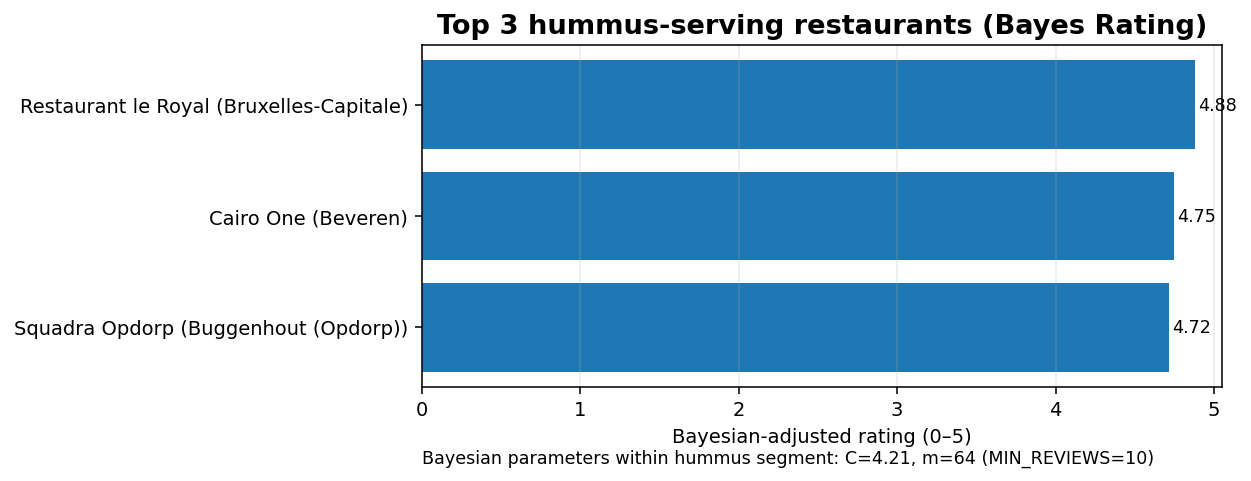

In [57]:
import matplotlib.pyplot as plt

cols = ["restaurant","city","hummus_items","rating","rating_count","bayes_rating"]
display(top3_who[cols].reset_index(drop=True))

# Plot (barh)
plot_df = top3_who.sort_values("bayes_rating", ascending=True).copy()
labels = plot_df["restaurant"] + " (" + plot_df["city"] + ")"

fig, ax = plt.subplots(figsize=(9, 3.6), dpi=140)
ax.barh(labels, plot_df["bayes_rating"])

# Value labels
for y, v in enumerate(plot_df["bayes_rating"].values):
	ax.text(v + 0.02, y, f"{v:.2f}", va="center", fontsize=9)

ax.set_xlim(0, 5.05)
ax.set_xlabel("Bayesian-adjusted rating (0–5)")
ax.set_title("Top 3 hummus-serving restaurants (Bayes Rating)", fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")

# Small parameter note (optional but transparent)
ax.text(
	0.0, -0.18,
	f"Bayesian parameters within hummus segment: C={C:.2f}, m={m:.0f} (MIN_REVIEWS={MIN_REVIEWS})",
	transform=ax.transAxes,
	ha="left", va="top", fontsize=9
)

plt.tight_layout()
plt.show()


## WHO - Most Hummus varierty side

restaurant       city  hummus_items  rating  \
0  BetoBe - Lebanese Street food   Waterloo            27     4.2   
1     Beïrut-Restaurant Libanais  Ganshoren            18     4.3   
2                          Sesam   Kortrijk            15     3.9   

   rating_count  bayes_rating  
0            59      4.207478  
1           253      4.282712  
2            77      4.042693

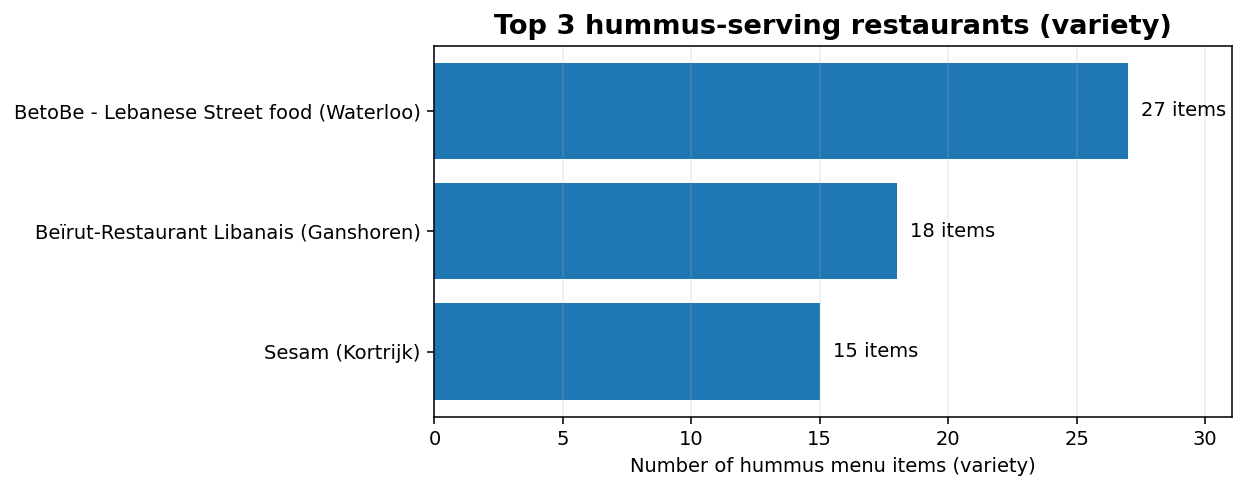

In [56]:
import matplotlib.pyplot as plt

# Top 3 by variety (primary), tie-breakers optional
top3_who_var = hummus_rest.sort_values(
	["hummus_items", "rating_count", "bayes_rating"],  # tie-breakers optional
	ascending=[False, False, False]
).head(3).copy()

cols = ["restaurant","city","hummus_items","rating","rating_count","bayes_rating"]
display(top3_who_var[cols].reset_index(drop=True))

# Plot: bar length = variety (hummus_items)
plot_df = top3_who_var.sort_values("hummus_items", ascending=True).copy()
labels = plot_df["restaurant"] + " (" + plot_df["city"] + ")"
vals = plot_df["hummus_items"].astype(int).values

fig, ax = plt.subplots(figsize=(9, 3.6), dpi=140)
ax.barh(labels, vals)

# Value labels at end of bars (variety count)
for y, v in enumerate(vals):
	ax.text(v + 0.5, y, f"{v} items", va="center", fontsize=10)

ax.set_xlabel("Number of hummus menu items (variety)")
ax.set_title("Top 3 hummus-serving restaurants (variety)", fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")

# Add some right padding so labels don't clip
ax.set_xlim(0, max(vals) * 1.15)

plt.tight_layout()
plt.show()


## WHO — Top hummus specialists (min hummus items)

restaurant                city  hummus_items  rating_count  \
0         Restaurant le Royal  Bruxelles-Capitale            13           359   
1  Beïrut-Restaurant Libanais           Ganshoren            18           253   
2     Les délices de l'Orient            Waterloo            10            10   

   bayes_rating  
0      4.881134  
1      4.282712  
2      4.239456

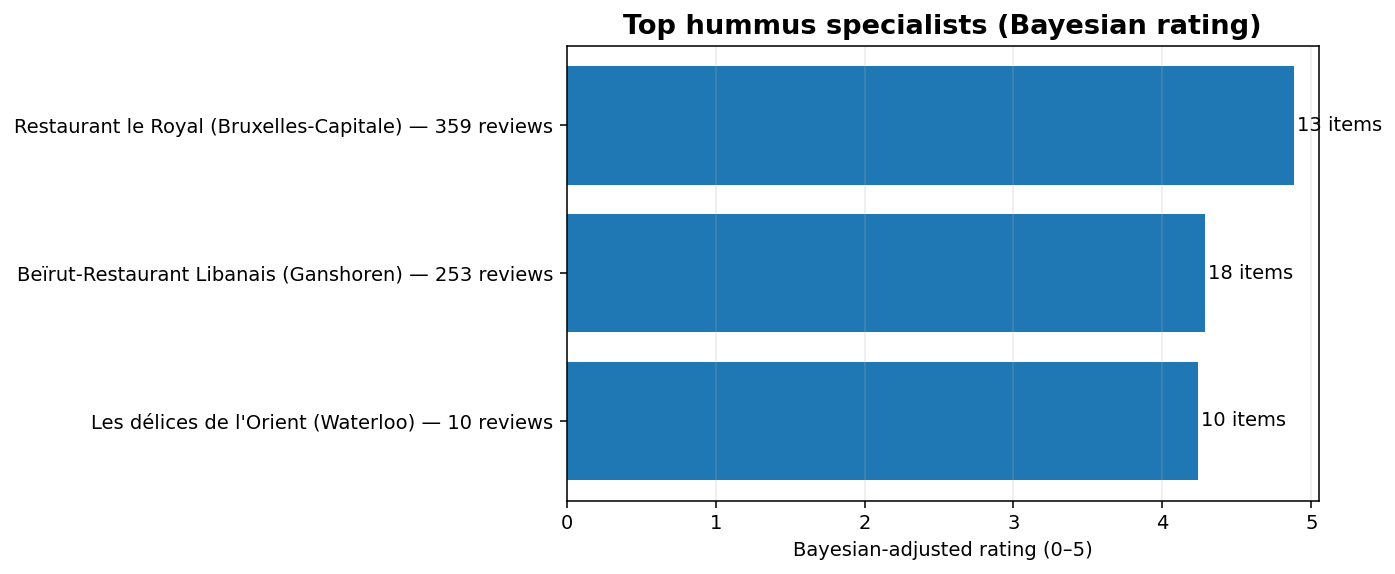

In [55]:
import matplotlib.pyplot as plt

MIN_HUMMUS_ITEMS = 10
MIN_REVIEWS = 10
TOP_N = 3

# Specialists filter
hummus_spec = hummus_rest[
	(hummus_rest["hummus_items"] >= MIN_HUMMUS_ITEMS) &
	(hummus_rest["rating_count"] >= MIN_REVIEWS)
].copy()

# Rank by Bayesian-adjusted rating
top_hummus = hummus_spec.sort_values(
	["bayes_rating", "rating_count", "hummus_items"],
	ascending=[False, False, False]
).head(TOP_N).copy()

# Table (no raw rating)
cols = ["restaurant","city","hummus_items","rating_count","bayes_rating"]
display(top_hummus[cols].reset_index(drop=True))

# Plot (barh) — bars are Bayesian rating; labels show review count; end labels show hummus items
plot_df = top_hummus.sort_values("bayes_rating", ascending=True).copy()
labels = (
	plot_df["restaurant"] + " (" + plot_df["city"] + ") — "
	+ plot_df["rating_count"].astype(int).astype(str) + " reviews"
)

vals = plot_df["bayes_rating"].astype(float).values
items = plot_df["hummus_items"].astype(int).values

fig, ax = plt.subplots(figsize=(10, 4.2), dpi=140)
ax.barh(labels, vals)

# End-of-bar label: hummus variety count
for y, (v, n) in enumerate(zip(vals, items)):
	ax.text(v + 0.02, y, f"{n} items", va="center", fontsize=10)

ax.set_xlim(0, 5.05)
ax.set_xlabel("Bayesian-adjusted rating (0–5)")
ax.set_title(f"Top hummus specialists (Bayesian rating)",
			 fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")

plt.tight_layout()
plt.show()


## Combined version:

restaurant                city  hummus_items  \
0  BetoBe - Lebanese Street food            Waterloo            27   
1            Restaurant le Royal  Bruxelles-Capitale            13   
2     Beïrut-Restaurant Libanais           Ganshoren            18   

   rating_count  bayes_rating     score  
0            59      4.207478  3.769841  
1           359      4.881134  3.760096  
2           253      4.282712  3.613576

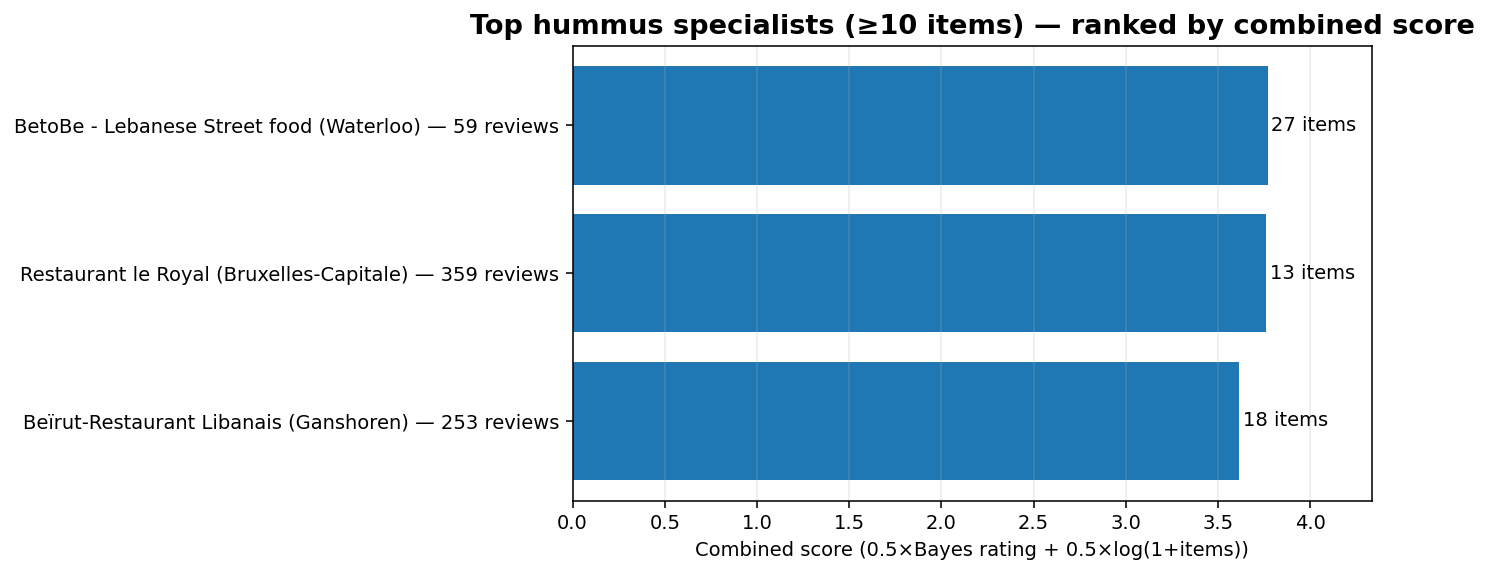

In [58]:
MIN_HUMMUS_ITEMS = 10
MIN_REVIEWS = 10
TOP_N = 3

# Specialists filter
hummus_spec = hummus_rest[
	(hummus_rest["hummus_items"] >= MIN_HUMMUS_ITEMS) &
	(hummus_rest["rating_count"] >= MIN_REVIEWS)
].copy()

# Combined score (Bayes + Variety)
hummus_spec["variety_term"] = np.log1p(hummus_spec["hummus_items"].astype(float))
hummus_spec["score"] = 0.5 * hummus_spec["bayes_rating"].astype(float) + 0.5 * hummus_spec["variety_term"]

# Rank by combined score (tie-breakers optional)
top_hummus_score = hummus_spec.sort_values(
	["score", "bayes_rating", "rating_count", "hummus_items"],
	ascending=[False, False, False, False]
).head(TOP_N).copy()

# Table
cols = ["restaurant","city","hummus_items","rating_count","bayes_rating","score"]
display(top_hummus_score[cols].reset_index(drop=True))

# Plot (barh) — bars = combined score, end labels = hummus items
plot_df = top_hummus_score.sort_values("score", ascending=True).copy()
labels = (
	plot_df["restaurant"] + " (" + plot_df["city"] + ") — "
	+ plot_df["rating_count"].astype(int).astype(str) + " reviews"
)

vals = plot_df["score"].astype(float).values
items = plot_df["hummus_items"].astype(int).values

fig, ax = plt.subplots(figsize=(10, 4.2), dpi=140)
ax.barh(labels, vals)

for y, (v, n) in enumerate(zip(vals, items)):
	ax.text(v + 0.02, y, f"{n} items", va="center", fontsize=10)

ax.set_xlabel("Combined score (0.5×Bayes rating + 0.5×log(1+items))")
ax.set_title(f"Top hummus specialists (≥{MIN_HUMMUS_ITEMS} items) — ranked by combined score",
			 fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")

# Add right padding so labels don't clip
ax.set_xlim(0, max(vals) * 1.15)

plt.tight_layout()
plt.show()


## Combination

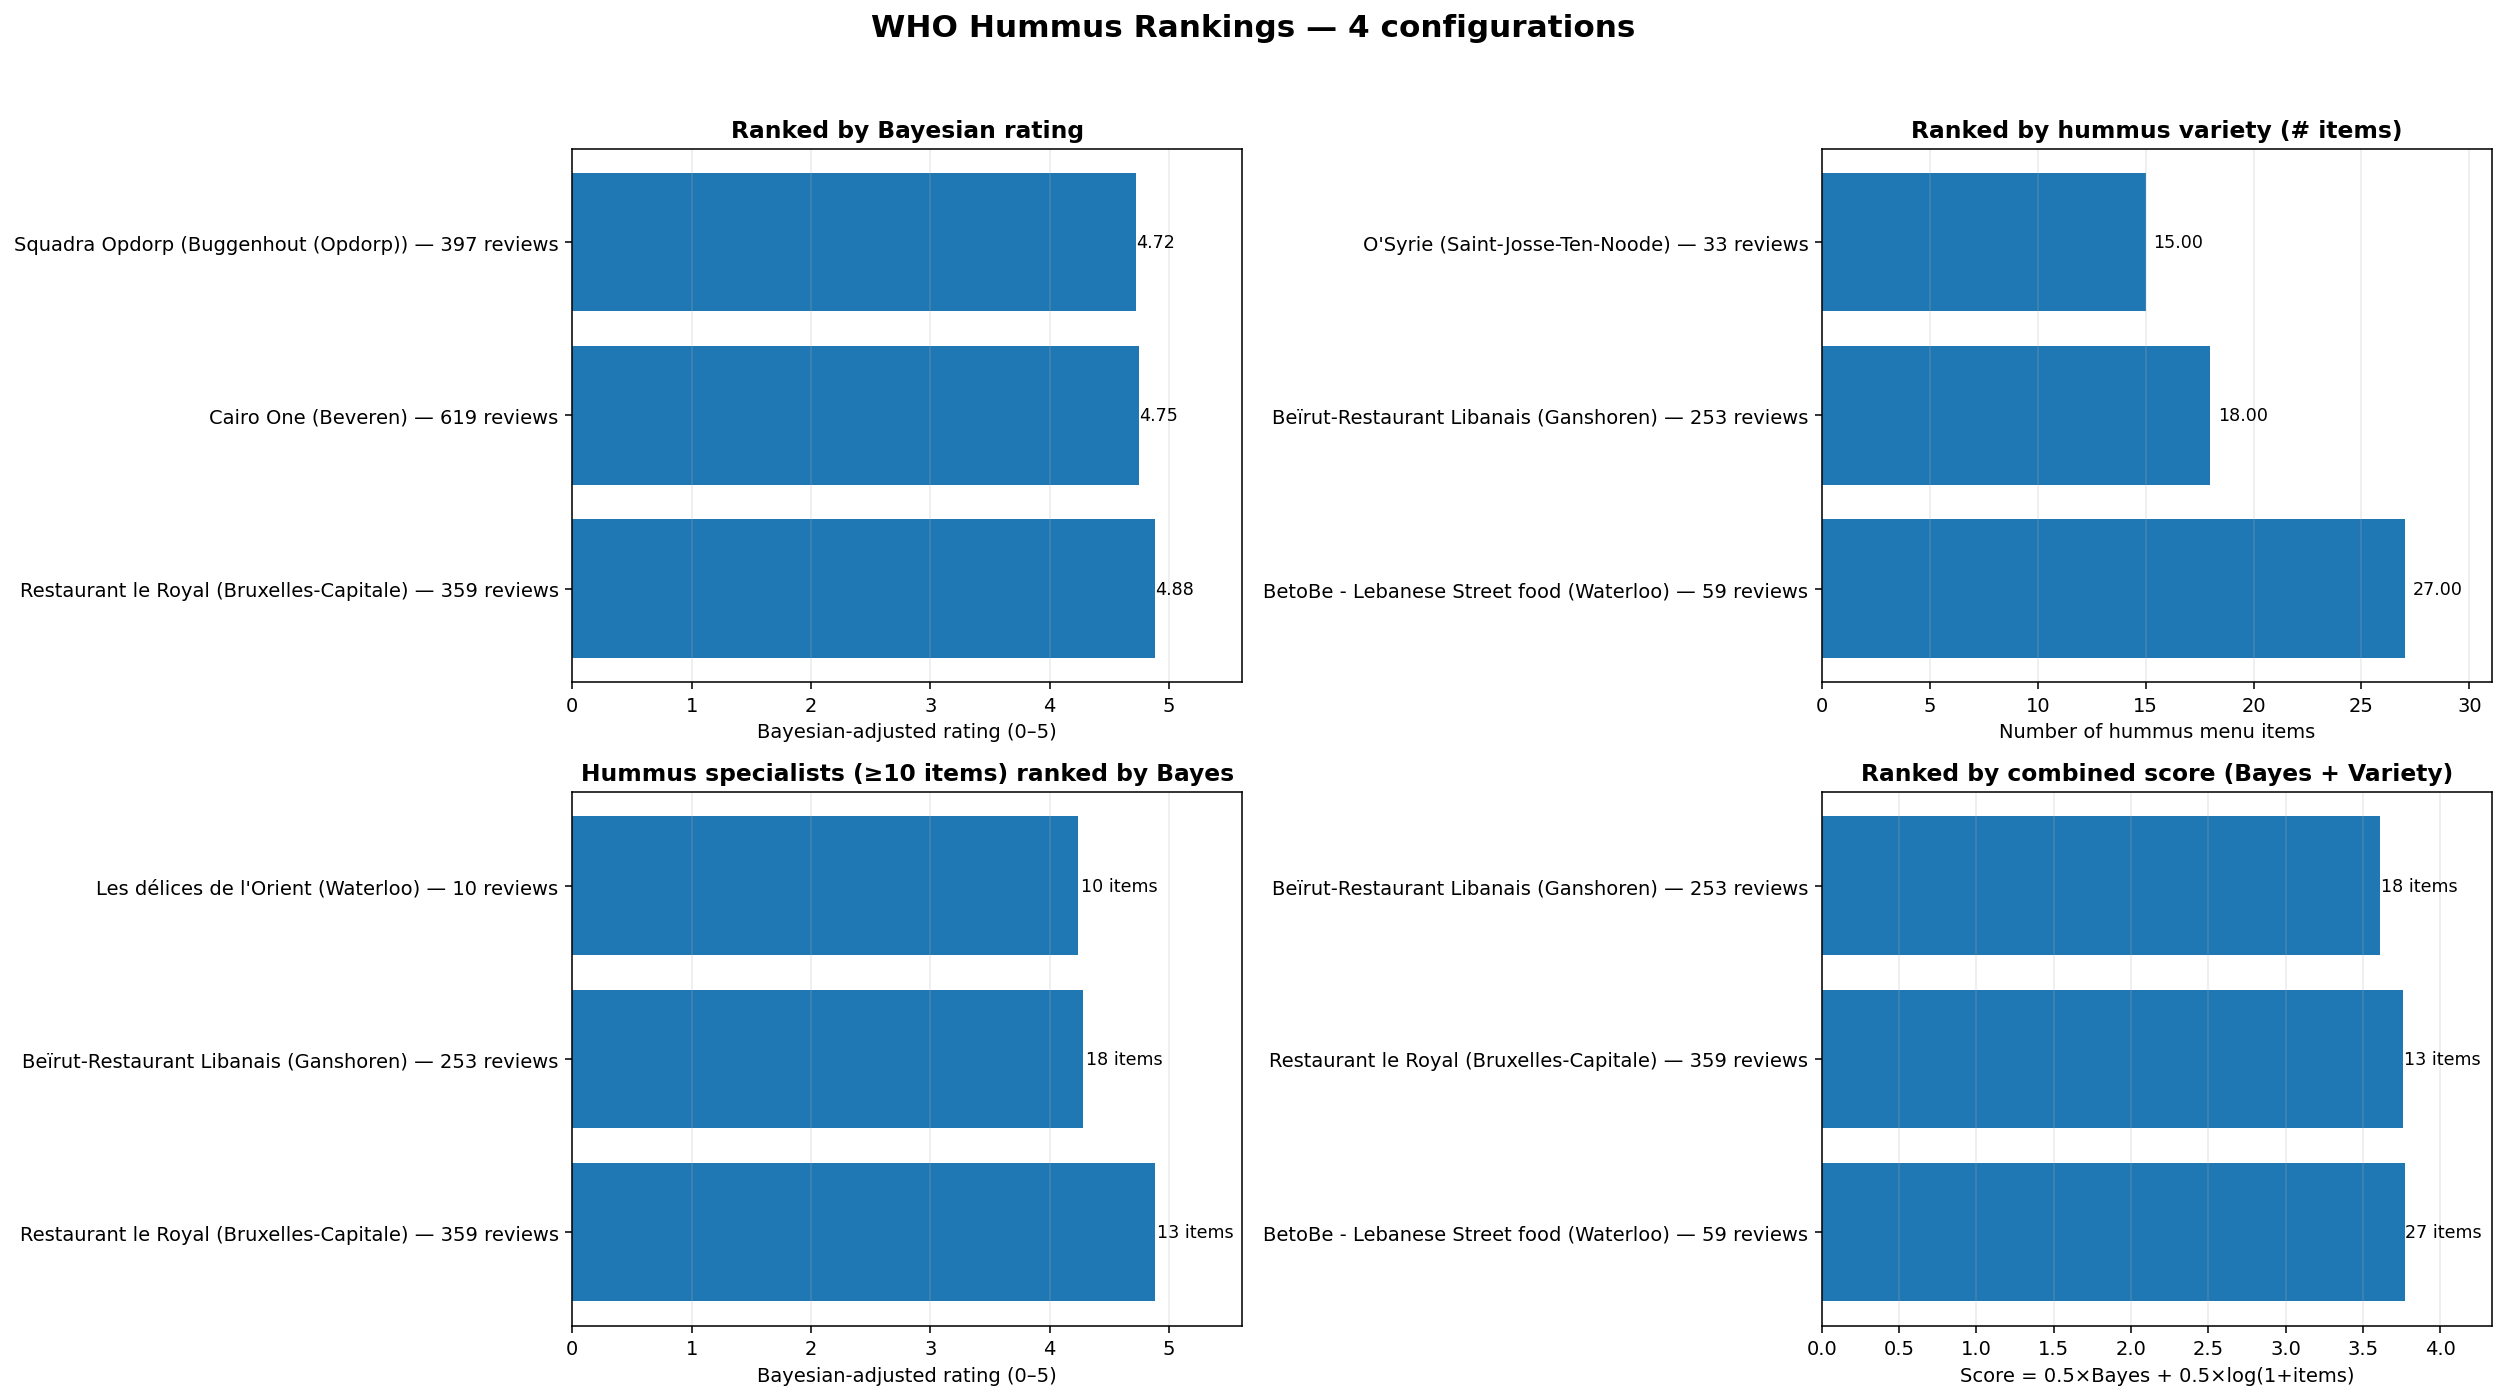

In [60]:

TOP_N = 3
MIN_SPEC_ITEMS = 10
MIN_SPEC_REVIEWS = 10

# Safety: ensure numeric
h = hummus_rest.copy()
h["hummus_items"] = h["hummus_items"].astype(int)
h["rating_count"] = h["rating_count"].astype(int)
h["bayes_rating"] = h["bayes_rating"].astype(float)

# 1) Ranked by Bayesian rating
df_bayes = h.sort_values(
	["bayes_rating", "rating_count", "hummus_items"],
	ascending=[False, False, False]
).head(TOP_N).copy()

# 2) Ranked by number of items (variety)
df_var = h.sort_values(
	["hummus_items", "bayes_rating", "rating_count"],
	ascending=[False, False, False]
).head(TOP_N).copy()

# 3) Specialists (min items 10) ranked by Bayesian rating
df_spec = h[
	(h["hummus_items"] >= MIN_SPEC_ITEMS) &
	(h["rating_count"] >= MIN_SPEC_REVIEWS)
].sort_values(
	["bayes_rating", "rating_count", "hummus_items"],
	ascending=[False, False, False]
).head(TOP_N).copy()

# 4) Combination score
h["score"] = 0.5 * h["bayes_rating"] + 0.5 * np.log1p(h["hummus_items"].astype(float))
df_combo = h.sort_values(
	["score", "bayes_rating", "rating_count", "hummus_items"],
	ascending=[False, False, False, False]
).head(TOP_N).copy()

def plot_barh(ax, df, value_col, title, xlabel, end_label_mode="value"):
	# Sort ascending for barh, so best ends up on top after invert
	d = df.sort_values(value_col, ascending=True).copy()

	labels = (
		d["restaurant"].astype(str)
		+ " (" + d["city"].astype(str) + ")"
		+ " — " + d["rating_count"].astype(int).astype(str) + " reviews"
	)

	vals = d[value_col].astype(float).values
	items = d["hummus_items"].astype(int).values

	ax.barh(labels, vals)
	ax.set_title(title, fontsize=12, fontweight="bold")
	ax.set_xlabel(xlabel)
	ax.grid(True, axis="x", alpha=0.25)
	ax.grid(False, axis="y")

	# End labels
	xpad = (vals.max() - vals.min()) * 0.03 if vals.max() > vals.min() else 0.05
	for y, (v, n) in enumerate(zip(vals, items)):
		if end_label_mode == "items":
			ax.text(v + xpad, y, f"{n} items", va="center", fontsize=9)
		else:
			ax.text(v + xpad, y, f"{v:.2f}", va="center", fontsize=9)

	# Padding so labels don't clip
	ax.set_xlim(0, vals.max() * 1.15 if vals.max() > 0 else 1)
	ax.invert_yaxis()

fig, axs = plt.subplots(2, 2, figsize=(18, 10), dpi=140)

plot_barh(
	axs[0, 0], df_bayes, "bayes_rating",
	"Ranked by Bayesian rating",
	"Bayesian-adjusted rating (0–5)",
	end_label_mode="value"
)

plot_barh(
	axs[0, 1], df_var, "hummus_items",
	"Ranked by hummus variety (# items)",
	"Number of hummus menu items",
	end_label_mode="value"  # shows the item count as value already
)

plot_barh(
	axs[1, 0], df_spec, "bayes_rating",
	f"Hummus specialists (≥{MIN_SPEC_ITEMS} items) ranked by Bayes",
	"Bayesian-adjusted rating (0–5)",
	end_label_mode="items"  # show variety at end
)

plot_barh(
	axs[1, 1], df_combo, "score",
	"Ranked by combined score (Bayes + Variety)",
	"Score = 0.5×Bayes + 0.5×log(1+items)",
	end_label_mode="items"  # show variety at end
)

fig.suptitle("WHO Hummus Rankings — 4 configurations", fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Insights:

1. Different winners depending on the objective.

    - Bayesian rating (quality-first): highlights restaurants that offer some Hummus with the strongest, most reliable customer satisfaction.

    - Variety (items-first): surfaces restaurants that offer the widest hummus selection, regardless of ratings.

    - Specialists (≥10 items + Bayes): focuses on restaurants that are truly invested in hummus and also score well.

    - Combined score: balances quality + variety, and tends to favor restaurants that are strong on both dimensions.

2. Key visible patterns:

    - BetoBe (Waterloo) dominates the variety ranking (27 hummus items) +  and the combined score Top 3 → strong menu breadth, decent quality.

    - Beïrut-Restaurant Libanais (Ganshoren) appears in Variety, Specialists, and Combined → consistent all-rounder also.

    - Restaurant le Royal (Bruxelles-Capitale) appears in Bayes, Specialists, and Combined → strong candidate for “premium hummus experience” positioning.



# OQ1: Where can Takeaway win market share tomorrow?

In [13]:
import pandas as pd
import numpy as np

def norm_key(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)
    s = s.replace({"nan": None, "None": None, "": None})
    return s

# Reload fresh (avoid previously-mutated dfs)
lr  = pd.read_sql("SELECT location_id, restaurant_id FROM locations_to_restaurants;", con)
loc = pd.read_sql("SELECT ID, postalCode, latitude, longitude FROM locations;", con)
mi  = pd.read_sql("SELECT primarySlug, price FROM menuItems WHERE price IS NOT NULL;", con)

# Normalize join keys
lr["loc_key"] = norm_key(lr["location_id"])
lr["slug"]    = norm_key(lr["restaurant_id"])      # <-- THIS is the restaurant slug
loc["loc_key"] = norm_key(loc["ID"])

# Clean postal codes
loc["postal_code"] = loc["postalCode"].astype(str).str.strip()
loc = loc[loc["postal_code"].notna()]
loc = loc[~loc["postal_code"].str.contains(r"[A-Za-z]", regex=True)]

# Quick sanity check: slug overlap with menuItems.primarySlug
mi["primarySlug"] = norm_key(mi["primarySlug"])
print("slug ∩ menuItems.primarySlug:", len(set(lr["slug"].dropna()) & set(mi["primarySlug"].dropna())))


slug ∩ menuItems.primarySlug: 4055


In [14]:
PRICE_CAP_EUR = 60

mi["price_eur"] = mi["price"].map(price_eur)
mi = mi.dropna(subset=["price_eur"])
mi = mi[mi["price_eur"].between(0.01, PRICE_CAP_EUR)].copy()

rest_price = (
    mi.groupby("primarySlug", as_index=False)
      .agg(
          n_items=("price_eur", "size"),
          med_item_price=("price_eur", "median"),
          mean_item_price=("price_eur", "mean"),
      )
)
rest_price.head()


primarySlug  n_items  med_item_price  mean_item_price
0          18-sushi       97            7.50         8.776289
1     2bangkok-thai       61           18.50        17.114754
2  2taste-antwerpen       42            8.50        10.214286
3        3piramiden      121           12.00        10.950413
4        4-seizoene      132           13.75        13.344697

In [15]:
lr_pc = (
    lr.dropna(subset=["loc_key", "slug"])
      .merge(loc[["loc_key", "postal_code"]], on="loc_key", how="inner")
      .merge(rest_price, left_on="slug", right_on="primarySlug", how="inner")
)

print("lr_pc:", lr_pc.shape)
lr_pc.head()


lr_pc: (157097, 9)


location_id          restaurant_id loc_key                   slug  \
0            0  chitir-chicken-ninove       0  chitir-chicken-ninove   
1            7  chitir-chicken-ninove       7  chitir-chicken-ninove   
2            8  chitir-chicken-ninove       8  chitir-chicken-ninove   
3           73  chitir-chicken-ninove      73  chitir-chicken-ninove   
4           77  chitir-chicken-ninove      77  chitir-chicken-ninove   

  postal_code            primarySlug  n_items  med_item_price  mean_item_price  
0        9400  chitir-chicken-ninove       86             7.5              9.2  
1        1760  chitir-chicken-ninove       86             7.5              9.2  
2        9402  chitir-chicken-ninove       86             7.5              9.2  
3        9473  chitir-chicken-ninove       86             7.5              9.2  
4        9450  chitir-chicken-ninove       86             7.5              9.2

In [16]:
MIN_RESTS_PER_PC_FOR_PRICE = 5

pc_stats = (
    lr_pc.groupby("postal_code", as_index=False)
         .agg(
             n_restaurants=("slug", "nunique"),
             basket_proxy=("med_item_price", "median"),   # robust: typical restaurant price level
             mean_rest_price=("med_item_price", "mean"),
             restaurants_with_prices=("slug", "nunique"),
         )
)

pc_stats = pc_stats[pc_stats["n_restaurants"] >= MIN_RESTS_PER_PC_FOR_PRICE].copy()
pc_stats.sort_values(["basket_proxy", "n_restaurants"], ascending=[False, True]).head(20)


postal_code  n_restaurants  basket_proxy  mean_rest_price  \
174        3051              7       14.9500        13.550000   
393        8952              5       14.0000        12.200000   
347        8583              5       13.0000        14.690000   
1          1320              8       12.9750        11.775000   
110        2382              6       12.7500        11.148333   
318        8431             10       12.7500        12.520000   
100        2322              6       12.7375        10.212500   
337        8552              7       12.5000        11.914286   
346        8582              7       12.5000        12.671429   
320        8433              8       12.5000        11.718750   
109        2381              9       12.5000        10.610000   
221        3401             11       12.5000        11.354545   
99         2321              7       12.4750        10.467857   
266        3722             10       12.2500        11.455000   
97         2310             14       12.2375        10.485714   
339        8554              8       12.2250        11.831250   
172        3040             26       12.2250        12.146051   
101        2323              9       12.0000        10.308333   
107        2370              9       12.0000        11.146111   
344        8580              9       12.0000        11.300000   

     restaurants_with_prices  
174                        7  
393                        5  
347                        5  
1                          8  
110                        6  
318                       10  
100                        6  
337                        7  
346                        7  
320                        8  
109                        9  
221                       11  
99                         7  
266                       10  
97                        14  
339                        8  
172                       26  
101                        9  
107                        9  
344                        9

In [17]:
MIN_RESTS_PER_PC_FOR_PRICE = 5

pc_stats = (
    lr_pc.groupby("postal_code", as_index=False)
         .agg(
             n_restaurants=("slug", "nunique"),
             basket_proxy=("med_item_price", "median"),   # proxy: typical price level of deliverable restaurants
             mean_rest_price=("med_item_price", "mean"),
             n_rows=("slug", "size"),
         )
)

pc_stats = pc_stats[pc_stats["n_restaurants"] >= MIN_RESTS_PER_PC_FOR_PRICE].copy()
pc_stats.describe(include="all")


postal_code  n_restaurants  basket_proxy  mean_rest_price        n_rows
count          496     496.000000    496.000000       496.000000    496.000000
unique         496            NaN           NaN              NaN           NaN
top           1140            NaN           NaN              NaN           NaN
freq             1            NaN           NaN              NaN           NaN
mean           NaN      54.512097      9.600232         9.620325    316.506048
std            NaN      88.123375      1.497105         1.050297    993.150697
min            NaN       5.000000      4.400000         6.879381      5.000000
25%            NaN      14.000000      8.500000         8.889172     32.000000
50%            NaN      25.000000      9.950000         9.507538     94.500000
75%            NaN      51.000000     10.750000        10.312500    260.000000
max            NaN     603.000000     14.950000        14.690000  16992.000000

In [18]:
LOW_COV_Q = 0.20     # bottom 20% coverage
HIGH_VALUE_Q = 0.80  # top 20% basket proxy

cov_thr = float(pc_stats["n_restaurants"].quantile(LOW_COV_Q))
val_thr = float(pc_stats["basket_proxy"].quantile(HIGH_VALUE_Q))

pc_stats["underserved"] = pc_stats["n_restaurants"] <= cov_thr
pc_stats["high_value"]  = pc_stats["basket_proxy"] >= val_thr

# Normalize for scoring
pc_stats["cov_norm"] = (pc_stats["n_restaurants"] - pc_stats["n_restaurants"].min()) / (
    pc_stats["n_restaurants"].max() - pc_stats["n_restaurants"].min()
)
pc_stats["value_norm"] = (pc_stats["basket_proxy"] - pc_stats["basket_proxy"].min()) / (
    pc_stats["basket_proxy"].max() - pc_stats["basket_proxy"].min()
)

# Expansion score: reward high value, penalize high coverage
pc_stats["expansion_score"] = (1 - pc_stats["cov_norm"]) * pc_stats["value_norm"]

targets = pc_stats[pc_stats["underserved"] & pc_stats["high_value"]].copy()

print("Underserved threshold (coverage <=):", cov_thr)
print("High-value threshold (basket_proxy >=):", val_thr)
print("Targets:", len(targets))

targets.sort_values("expansion_score", ascending=False).head(20)


Underserved threshold (coverage <=): 12.0
High-value threshold (basket_proxy >=): 11.0
Targets: 40


postal_code  n_restaurants  basket_proxy  mean_rest_price  n_rows  \
174        3051              7       14.9500        13.550000       7   
393        8952              5       14.0000        12.200000       5   
347        8583              5       13.0000        14.690000       5   
1          1320              8       12.9750        11.775000       8   
110        2382              6       12.7500        11.148333       6   
100        2322              6       12.7375        10.212500       6   
318        8431             10       12.7500        12.520000      10   
346        8582              7       12.5000        12.671429       7   
337        8552              7       12.5000        11.914286       7   
320        8433              8       12.5000        11.718750      32   
99         2321              7       12.4750        10.467857       7   
109        2381              9       12.5000        10.610000      27   
221        3401             11       12.5000        11.354545      44   
339        8554              8       12.2250        11.831250       8   
266        3722             10       12.2500        11.455000      10   
107        2370              9       12.0000        11.146111      45   
101        2323              9       12.0000        10.308333       9   
344        8580              9       12.0000        11.300000       9   
396        8956              7       11.9500        11.992857       7   
98         2320             11       12.0000        10.397727      22   

     underserved  high_value  cov_norm  value_norm  expansion_score  
174         True        True  0.003344    1.000000         0.996656  
393         True        True  0.000000    0.909953         0.909953  
347         True        True  0.000000    0.815166         0.815166  
1           True        True  0.005017    0.812796         0.808719  
110         True        True  0.001672    0.791469         0.790146  
100         True        True  0.001672    0.790284         0.788963  
318         True        True  0.008361    0.791469         0.784852  
346         True        True  0.003344    0.767773         0.765205  
337         True        True  0.003344    0.767773         0.765205  
320         True        True  0.005017    0.767773         0.763921  
99          True        True  0.003344    0.765403         0.762843  
109         True        True  0.006689    0.767773         0.762637  
221         True        True  0.010033    0.767773         0.760069  
339         True        True  0.005017    0.741706         0.737985  
266         True        True  0.008361    0.744076         0.737854  
107         True        True  0.006689    0.720379         0.715561  
101         True        True  0.006689    0.720379         0.715561  
344         True        True  0.006689    0.720379         0.715561  
396         True        True  0.003344    0.715640         0.713246  
98          True        True  0.010033    0.720379         0.713151

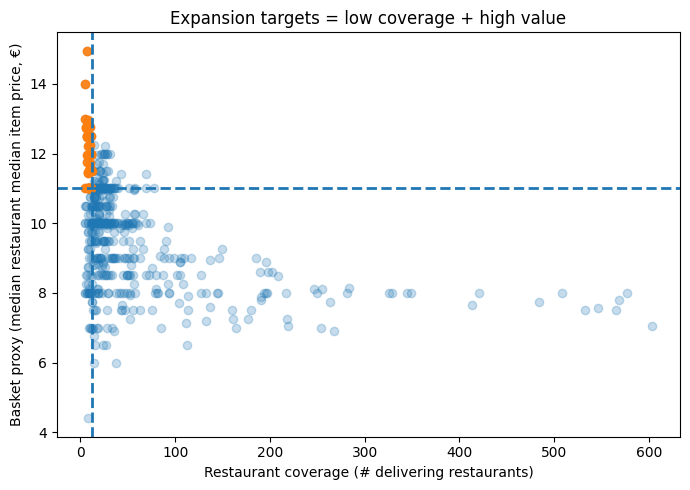

In [19]:
plt.figure(figsize=(7,5))
plt.scatter(pc_stats["n_restaurants"], pc_stats["basket_proxy"], alpha=0.25)

plt.scatter(targets["n_restaurants"], targets["basket_proxy"], alpha=0.9)

plt.axvline(cov_thr, linestyle="--", linewidth=2)
plt.axhline(val_thr, linestyle="--", linewidth=2)

plt.xlabel("Restaurant coverage (# delivering restaurants)")
plt.ylabel("Basket proxy (median restaurant median item price, €)")
plt.title("Expansion targets = low coverage + high value")
plt.tight_layout()
plt.show()


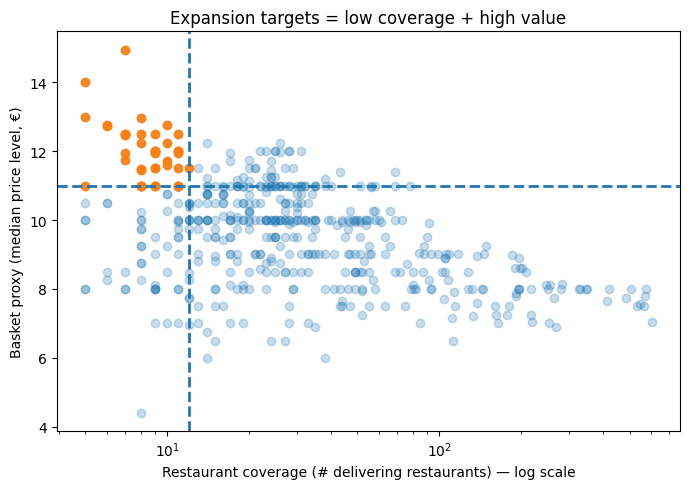

In [21]:
plt.figure(figsize=(7,5))
plt.scatter(pc_stats["n_restaurants"], pc_stats["basket_proxy"], alpha=0.25)
plt.scatter(targets["n_restaurants"], targets["basket_proxy"], alpha=0.9)

plt.axvline(cov_thr, linestyle="--", linewidth=2)
plt.axhline(val_thr, linestyle="--", linewidth=2)

plt.xscale("log")
plt.xlabel("Restaurant coverage (# delivering restaurants) — log scale")
plt.ylabel("Basket proxy (median price level, €)")
plt.title("Expansion targets = low coverage + high value")
plt.tight_layout()
plt.show()


In [20]:
from folium.plugins import MarkerCluster
import folium

# centroid per postal code
geo_pc = (
    loc.groupby("postal_code", as_index=False)
       .agg(lat=("latitude", "mean"), lon=("longitude", "mean"))
)

top_targets = targets.sort_values("expansion_score", ascending=False).head(30).copy()
top_targets_map = top_targets.merge(geo_pc, on="postal_code", how="inner").dropna(subset=["lat","lon"])

center = [top_targets_map["lat"].median(), top_targets_map["lon"].median()]
m_targets = folium.Map(location=center, zoom_start=9, tiles="cartodbpositron")

cluster = MarkerCluster(name="Expansion targets (Top 30)")
for _, r in top_targets_map.iterrows():
    popup = folium.Popup(
        f"<b>Postal code:</b> {r['postal_code']}<br>"
        f"<b>Coverage:</b> {int(r['n_restaurants'])} restaurants<br>"
        f"<b>Basket proxy:</b> €{r['basket_proxy']:.2f}<br>"
        f"<b>Score:</b> {r['expansion_score']:.3f}",
        max_width=280
    )
    folium.Marker(
        location=[float(r["lat"]), float(r["lon"])],
        tooltip=f"{r['postal_code']} | cov={int(r['n_restaurants'])} | €{r['basket_proxy']:.2f}",
        popup=popup,
        icon=folium.Icon(icon="bullseye", prefix="fa")
    ).add_to(cluster)

cluster.add_to(m_targets)
folium.LayerControl(collapsed=False).add_to(m_targets)

from pathlib import Path
out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)

path = out / f"expansion_targets_q{int(LOW_COV_Q*100)}_q{int(HIGH_VALUE_Q*100)}.html"
m_targets.save(str(path))
path



WindowsPath('report/maps/expansion_targets_q20_q80.html')

# OQ2: “Pricing mismatch” opportunities

## Business question

Which restaurants are overpriced vs their local market and underperform on ratings?
→ actionable for partners: “adjust pricing / improve quality to match local expectations.”

Assumptions (state clearly)

Local market = city (from restaurants.city)

Price proxy per restaurant = median menu item price (robust)

Rating = Bayesian-adjusted rating (stability vs low reviews)

Only consider restaurants with enough data: MIN_ITEMS, MIN_REVIEWS

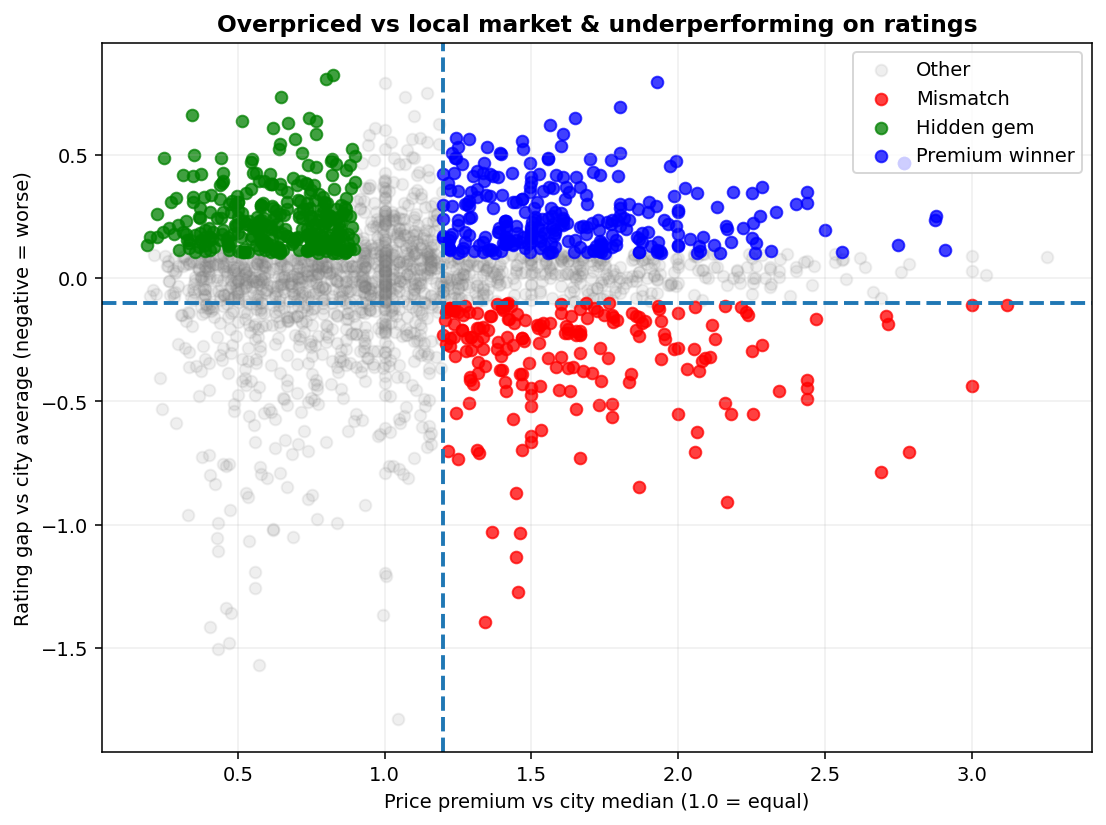

In [67]:
# ----------------------------
# Plot (single scatter) with 4 legend entries + requested colors
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 6), dpi=140)

colors = {
	"Mismatch": "red",          # 🔴
	"Hidden gem": "green",      # 🟢
	"Premium winner": "blue",   # 🔵
	"Other": "gray",            # ⚪
}

# Plot in this order so "Other" stays in the background, but still appears in legend
plot_order = ["Other", "Mismatch", "Hidden gem", "Premium winner"]

for seg in plot_order:
	d = df2[df2["segment"] == seg]
	alpha = 0.12 if seg == "Other" else 0.75
	ax.scatter(
		d["price_premium"],
		d["rating_gap"],
		alpha=alpha,
		label=seg,
		c=colors[seg],
	)

# Threshold lines
ax.axvline(PREMIUM_THR, linestyle="--", linewidth=2)
ax.axhline(UNDERPERF_THR, linestyle="--", linewidth=2)

ax.set_xlabel("Price premium vs city median (1.0 = equal)")
ax.set_ylabel("Rating gap vs city average (negative = worse)")
ax.set_title("Overpriced vs local market & underperforming on ratings", fontweight="bold")
ax.grid(True, alpha=0.2)

# Legend (explicit order, includes Other)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [66]:
import numpy as np
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path


rest_geo = pd.read_sql("""
SELECT primarySlug, latitude AS lat, longitude AS lon
FROM restaurants
WHERE primarySlug IS NOT NULL AND latitude IS NOT NULL AND longitude IS NOT NULL
""", con)

rest_geo["lat"] = pd.to_numeric(rest_geo["lat"], errors="coerce")
rest_geo["lon"] = pd.to_numeric(rest_geo["lon"], errors="coerce")
rest_geo = rest_geo.dropna(subset=["lat","lon"]).copy()

df_map = df2.merge(rest_geo, on="primarySlug", how="inner").copy()

# 2) Normalize segment labels (handles both “short” and your older “long” labels)
seg_map = {
    "Mismatch (overpriced + underperforming)": "Mismatch",
    "Hidden gems (cheap + great ratings)": "Hidden gem",
    "Premium winners (expensive + great ratings)": "Premium winner",
    "Other restaurants": "Other",
}
df_map["segment"] = df_map["segment"].map(seg_map).fillna(df_map["segment"])
df_map["segment"] = df_map["segment"].where(df_map["segment"].isin(["Mismatch","Hidden gem","Premium winner","Other"]), "Other")

# ----------------------------
# MAP 
# ----------------------------
center = [df_map["lat"].median(), df_map["lon"].median()]
m_value = folium.Map(location=center, zoom_start=8, tiles="cartodbpositron")

layers = {
    "Mismatch": {
        "fg": folium.FeatureGroup(name="🔴 Mismatch (overpriced + underperforming)", show=True),
        "icon": dict(color="red", icon="exclamation-triangle", prefix="fa"),
        "cluster": MarkerCluster(disableClusteringAtZoom=12)
    },
    "Hidden gem": {
        "fg": folium.FeatureGroup(name="🟢 Hidden gems (cheap + great ratings)", show=True),
        "icon": dict(color="green", icon="leaf", prefix="fa"),
        "cluster": MarkerCluster(disableClusteringAtZoom=12)
    },
    "Premium winner": {
        "fg": folium.FeatureGroup(name="🔵 Premium winners (expensive + great ratings)", show=False),
        "icon": dict(color="blue", icon="star", prefix="fa"),
        "cluster": MarkerCluster(disableClusteringAtZoom=12)
    },
    "Other": {
        "fg": folium.FeatureGroup(name="⚪ Other restaurants", show=False),
        "icon": dict(color="gray", icon="cutlery", prefix="fa"),
        "cluster": MarkerCluster(disableClusteringAtZoom=12)
    }
}

for meta in layers.values():
    meta["cluster"].add_to(meta["fg"])
    meta["fg"].add_to(m_value)

for _, r in df_map.iterrows():
    seg = r["segment"]
    meta = layers[seg]

    popup_html = (
        f"<b>{r['restaurant']}</b><br>"
        f"City: {r['city']}<br>"
        f"Segment: <b>{seg}</b><br>"
        f"Price premium vs city median: <b>{r.get('price_premium', np.nan):.2f}×</b><br>"
        f"Rating gap vs city avg: <b>{r.get('rating_gap', np.nan):+.2f}</b><br>"
        f"Bayes rating: {r.get('bayes_rating', np.nan):.2f}<br>"
        f"Median item price (€): {r.get('med_item_price', np.nan):.2f}<br>"
        f"Mismatch score: {r.get('mismatch_score', np.nan):.3f}"
    )

    folium.Marker(
        location=[float(r["lat"]), float(r["lon"])],
        tooltip=f"{r['restaurant']} | {seg}",
        popup=folium.Popup(popup_html, max_width=350),
        icon=folium.Icon(**meta["icon"]),
    ).add_to(meta["cluster"])

folium.LayerControl(collapsed=False).add_to(m_value)

out = Path("report/maps")
out.mkdir(parents=True, exist_ok=True)
path = out / "pricing_mismatch_map.html"  
m_value.save(str(path))
path


WindowsPath('report/maps/pricing_mismatch_map.html')

## Insights :

1. Mismatch (Red): overpriced + underperforming:

    - Clear partner action: either price down or quality/ops up (food consistency, delivery time, packaging).

    - These points are the most fixable for Takeaway because they’re already in-market but misaligned with expectations.

2. Premium winners (Blue): expensive + great ratings

    - These are proof that premium pricing works when quality supports it.

    - Action: feature and replicate (use as benchmarks, promote in app, learn what they do well).

3. Hidden gems (Green): cheap + great ratings

    - Best candidates for promotion / discovery boost.

    - Action: “Best value” badges, targeted campaigns.

4. Other (Grey): middle mass

    - Most restaurants cluster near local norms.

    - Action: segment further later (by cuisine, delivery fee, delivery time, etc.) to categorize more.

5. Where Takeaway can win tomorrow:

    - Fastest lever = convert “Mismatch” restaurants into “Premium winners” or “Fair-price performers” : wins by improving perceived value (price vs experience) without needing new supply.

    - Growth lever = surface “Hidden gems” (cheap + loved) to drive conversion and repeat: consumer-side win: better discovery increases order volume quickly.

    - Brand lever = highlight “Premium winners” to strengthen quality perception: compete against alternatives by showcasing premium success stories.
